# 0. Imports

In [1]:
# Data Processing
import cv2
import numpy as np

# Utilities
import io
import os
import shutil
import csv
from glob import glob
from tqdm import tqdm
import time
import datetime
import itertools
import math

# Visualisation
from IPython.display import Video, Image
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
print('Using Tensorflow: %s' % tf.__version__)
print('Using Keras: %s' % tf.keras.__version__)
print('Tensorflow Executing Eagerly: %s' % tf.executing_eagerly())
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Lambda, Activation, MaxPool2D, Dropout, Input, Concatenate, Layer
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import Loss
from tensorflow.math import sigmoid, log, reduce_mean
from tensorflow.nn import softmax
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow_addons.optimizers import MultiOptimizer
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

# Scikit
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

%load_ext tensorboard

Using Tensorflow: 2.6.0
Using Keras: 2.6.0
Tensorflow Executing Eagerly: True


# 1. High Level Implementation Architecture

<img src="images/HighLevelArchitecture.png" alt="High Level Architecture Implementation Architecture" class="bg-primary" width="1000px">
<center>High Level Architecture Implementation Architecture.</center>

# 2. Data | Loading

## 2.1 Introduction

We assume the following directory tree for loading data:

* Raw Data
    * data/videos/videoX/videoX.mp4 - Raw Video X
    * data/videos/videoX/videoX-phase.txt - Phase Annotations for Video X
    * data/videos/videoX/videoX-tool.txt - Tool Annotations for Video X
* TF Records
    * data/records/videoX.tfrecords - TF Record for Video X containing examples
    
Record examples are of the form: (frame, toolAnnotations, phaseAnnotations)   

## 2.2 Loading Data

Using AUTOTUNE for better performance

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

In [136]:
class DataLoader():
    '''Loading videos and annotations, and records based on video ID.'''
    
    def __init__(self, dataDir='data/videos', recordsDir='data/records', framesDir='data/frames'):
        '''
        Arguments:
         * dataDir - directory for initial raw videos
         * recordsDir - directory for saved TF records
         * framesDir - directory for saved frames
        '''        
        self.__dataDir = dataDir
        self.__recordsDir = recordsDir
        self.__framesDir = framesDir
    
    def __generateVideoFilesName(self, videoId):
        '''Generating file names using the following conventions:
            1. Digit values are prefixed with 0 (i.e. 01, 02)
            2. Data for video X are contained in files: videoX.mp4, videoX-tool.txt, videoX-phase.txt

        Arguments:
         * videoId - integer ID of video

        Return:
         * videoFileName
         * toolFileName - tool annotations
         * phaseFileName - phase annotations  
        '''
        videoIdString = str(videoId).zfill(2)
        videoFileName = "{}/video{}/video{}.mp4".format(self.__dataDir, videoIdString, videoIdString)
        toolFileName = '{}/video{}/video{}-tool.txt'.format(self.__dataDir, videoIdString, videoIdString)
        phaseFileName = '{}/video{}/video{}-phase.txt'.format(self.__dataDir, videoIdString, videoIdString)

        return videoFileName, toolFileName, phaseFileName
    
    def __readAnnotationCsvFiles(self, fileName):
        '''Reading annotation files, delimited with '\t'

        Arguments:
         * fileName - name of annotation file

        Return:
         * annotationRows
        '''

        with open(fileName, 'r') as file:
            reader = csv.reader(file, delimiter = '\t')

            annotationRows = []
            for row in reader:
                annotationRows.append(row)

            return annotationRows
        
    # Mangled names are not yet supported by AutoGraph, prefixing with one _ instead of two (__)
    def _decodeImage(self, image_data):
        image = tf.io.parse_tensor(image_data, out_type=np.uint8)
#         image = tf.cast(image, tf.float32) / 255.0 # convert image to floats in [0, 1] range        
        image = tf.cast(image, tf.float32) # convert image to floats in [0, 1] range
        image = tf.reshape(image, [227, 227, 3])
        
        return image
        
    # Mangled names are not yet supported by AutoGraph, prefixing with one _ instead of two (__)
    def _readRecord(self, serializedExample):
        """Parses TFRecord using a feature template, returning its features.

        Arguments:
         * serializedExample - current serialized example
        """

        # 1. Create features template
        # tf.string means bytestring, shape [] means single element
        featuresTemplate = {
          "frame"       : tf.io.FixedLenFeature([], tf.string), 
          "instruments" : tf.io.FixedLenFeature([], tf.string),
          "phase"       : tf.io.FixedLenFeature([], tf.float32)
        }

        # 2. Parse example using template
        parsedExample = tf.io.parse_single_example(serializedExample, featuresTemplate)

        # 3. Extract features. We need to parse the frame and tools from strings to their proper types.

        frameFeature = self._decodeImage(parsedExample["frame"])
    
        toolsFeature = tf.io.parse_tensor(parsedExample["instruments"], out_type=tf.float64)
        toolsFeature = tf.cast(toolsFeature, tf.float32)
        toolsFeature = tf.squeeze(tf.reshape(toolsFeature, [1, 7]))
        
        phaseFeature = parsedExample["phase"]
        phaseFeature = tf.squeeze(tf.reshape(phaseFeature, [1]))

        return {
            "frame": frameFeature,
            "toolsTarget": toolsFeature,
            "phaseTarget": phaseFeature
        }
    
    def loadRawVideoData(self, videoId): 
        '''Generating data file names and loading files for one video based on video ID.

        Arguments:
         * videoId -- integer ID of video

        Return:
         * videoCapture - raw video
         * toolAnnotationsWithHeader - raw tool annotations
         * phaseAnnotationsWithHeader - raw phase annotations  
        '''

        videoFileName, toolFileName, phaseFileName = self.__generateVideoFilesName(videoId)

        # 1. Reading Video Data
        videoCapture = cv2.VideoCapture(videoFileName)
        videoCapture.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        videoCapture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

        # 2. Reading Annotations
        toolAnnotationsWithHeader = self.__readAnnotationCsvFiles(toolFileName)
        phaseAnnotationsWithHeader = self.__readAnnotationCsvFiles(phaseFileName)

        return videoCapture, toolAnnotationsWithHeader, phaseAnnotationsWithHeader
    
    def loadRecordVideoData(self, videosId, subSet=0, ordered=False):
        '''Loading TF Records Dataset from file, based on videoId.         

        Arguments:
         * videosId - list of integer ID of each video
          * subSet - number of samples to load

        Return:
         * currentVideoDataset - tf.Dataset containing records
        '''

        # For optimal performance, reading from multiple files at once and disregarding data order. 
        # Order does not matter since we will be shuffling the data anyway.
        if not ordered:
            ignore_order = tf.data.Options()
            ignore_order.experimental_deterministic = False # disable order, increase speed
        

        videoFileNames = []
        for videoId in videosId:
            videoFileNames.append('{}/video{}.tfrecords'.format(self.__recordsDir, str(videoId).zfill(2)))
            
        # Automatically interleaves reads from multiple files
        currentVideoDataset = tf.data.TFRecordDataset(videoFileNames, num_parallel_reads=AUTOTUNE)
        
        
        # Uses data as soon as it streams in, rather than in its original order
        currentVideoDataset = currentVideoDataset.with_options(ignore_order)
        
        if subSet == 0:
            # Read entire dataset
            return currentVideoDataset.map(self._readRecord, num_parallel_calls=AUTOTUNE)
        
        else:
            
            # Take subSet number of samples from dataset
            return currentVideoDataset.take(subSet).map(self._readRecord, num_parallel_calls=AUTOTUNE)
        
        
    def inspectVideo(self, videoId, nRows=10):
        '''Inspecting Raw Data from file, based on videoId.

        Arguments:
         * videoId - integer ID of video
          * rows - number of annotations rows to inspect

        Return:
         * videoFileName
        '''
        
        videoFileName, toolFileName, phaseFileName = self.__generateVideoFilesName(videoId)
        
        toolAnnotationsWithHeader = self.__readAnnotationCsvFiles(toolFileName)
        phaseAnnotationsWithHeader = self.__readAnnotationCsvFiles(phaseFileName)

        # Displaying first nRows
        print("Annotations Sample: \n")
        print(toolAnnotationsWithHeader[:nRows])

        print("\n")
        # Displaying first nRows
        print("Phases Sample: \n")
        print(phaseAnnotationsWithHeader[:nRows])
        
        # Return video for display
        return videoFileName

## 2.3 Inspect Video

Inspecting Video with ID 4

In [137]:
dataLoader = DataLoader()
videoFile = dataLoader.inspectVideo(videoId=8, nRows=10)
Video(videoFile)

Annotations Sample: 

[['Frame', 'Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator', 'SpecimenBag'], ['0', '0', '0', '0', '0', '0', '0', '0'], ['25', '0', '0', '0', '0', '0', '0', '0'], ['50', '0', '0', '0', '0', '0', '0', '0'], ['75', '0', '0', '0', '0', '0', '0', '0'], ['100', '0', '0', '0', '0', '0', '0', '0'], ['125', '0', '0', '0', '0', '0', '0', '0'], ['150', '0', '0', '0', '0', '0', '0', '0'], ['175', '0', '0', '0', '0', '0', '0', '0'], ['200', '0', '0', '0', '0', '0', '0', '0']]


Phases Sample: 

[['Frame', 'Phase'], ['0', 'Preparation'], ['1', 'Preparation'], ['2', 'Preparation'], ['3', 'Preparation'], ['4', 'Preparation'], ['5', 'Preparation'], ['6', 'Preparation'], ['7', 'Preparation'], ['8', 'Preparation']]


# 3. Data | Processing

Focus on **label encoding**, **downsampling** to 1fps, and saving in **TFRecord** or **Frames** (for Sequence) format.

## 3.1 Annotations Processor
Processing annotation files by: Stripping Headers, Extracting Frame IDs and Labels. 
Creating tools and phase annotation dictionaries with frame ID as keys.

In [138]:
class AnnotationsPreProcessor():
    '''Processing annotation files by: Stripping Headers, Extracting Frame IDs and Labels. 
    Creating tools and phase annotation dictionaries with frame ID as keys.'''
    
    def __removeAnnotationHeaders(self, toolAnnotationsWithHeader, phaseAnnotationsWithHeader):
        toolAnnotationsPerFrame = np.array(toolAnnotationsWithHeader[1:])
        phaseAnnotationsPerFrame = np.array(phaseAnnotationsWithHeader[1:]) 

        return toolAnnotationsPerFrame, phaseAnnotationsPerFrame

    def __extractAnnotationFrames(self, toolAnnotationsPerFrame, phaseAnnotationsPerFrame):
        toolAnnotationFrameIds = toolAnnotationsPerFrame[:, 0].astype(int)
        phaseAnnotationFrameIds = phaseAnnotationsPerFrame[:, 0].astype(int)

        return toolAnnotationFrameIds, phaseAnnotationFrameIds

    def __extractAnnotationLabels(self, toolAnnotationsPerFrame, phaseAnnotationsPerFrame):
        toolAnnotationsLabels = toolAnnotationsPerFrame[:, 1:].astype(np.float64)
        phaseAnnotationsLabels = phaseAnnotationsPerFrame[:, 1:].ravel()

        return toolAnnotationsLabels, phaseAnnotationsLabels

    def __createDictionaries(self, toolAnnotationFrameIds, phaseAnnotationFrameIds, toolAnnotationsLabels, phaseAnnotationsLabels):
        toolAnnotationsDict = dict(zip(toolAnnotationFrameIds, toolAnnotationsLabels))
        phaseAnnotationsDict = dict(zip(phaseAnnotationFrameIds, phaseAnnotationsLabels))

        return toolAnnotationsDict, phaseAnnotationsDict
    
    def preProcessAnnotationsData(self, toolAnnotationsWithHeader, phaseAnnotationsWithHeader):
        '''Entry Point.

        Arguments:
         * toolAnnotationsWithHeader - raw tool annotations
         * phaseAnnotationsWithHeader - raw phase annotations  

        Return:
         * toolAnnotationsDict - processed tool annotations dictionary by frame ID
         * phaseAnnotationsDict - processed phase annotations dictionary by frame ID
        '''
        
        # 1. Removing Annotation Headers
        toolAnnotationsPerFrame, phaseAnnotationsPerFrame = self.__removeAnnotationHeaders(toolAnnotationsWithHeader, 
                                                                                           phaseAnnotationsWithHeader)
        
        # 2. Extracting Annotation Frames
        toolAnnotationFrameIds, phaseAnnotationFrameIds = self.__extractAnnotationFrames(toolAnnotationsPerFrame, 
                                                                                         phaseAnnotationsPerFrame)
        
        # 3. Extracting Annotation Labels
        toolAnnotationsLabels, phaseAnnotationsLabels = self.__extractAnnotationLabels(toolAnnotationsPerFrame, 
                                                                                       phaseAnnotationsPerFrame)
        
        # 4. Creating Dictionaries with Frame as Key and Annotation as Value
        toolAnnotationsDict, phaseAnnotationsDict = self.__createDictionaries(toolAnnotationFrameIds, 
                                                                                  phaseAnnotationFrameIds,
                                                                                  toolAnnotationsLabels,
                                                                                  phaseAnnotationsLabels)
        return toolAnnotationsDict, phaseAnnotationsDict

## 3.2 Data Converter
Converting Video Data from Raw to TFRecords or Frames

In [139]:
class DataConverter():
    '''Converting Video Data from Raw to TFRecords or Frames'''
    
    def __init__(self, frameStep=25, recordsDir='data/records', framesDir='data/frames'):
        """
        * __phaseToLabelEncoding - encoding map of phase Labels
        * __labelToPhaseDecoding - decoding map of phase Labels
        * __croppingAreas - cropping areas per video Id, to remove black frame
        
        Arguments:
         * frameStep - frames downsampling rate by skipping frames
         * recordsDir - folder of saved TF Records
         * framesDir - folder of saved Frames
        """
        
        self.__frameStep = frameStep # setting to 25 for downsampling to 1fps
        self.__recordsDir = recordsDir
        self.__framesDir = framesDir
        
        self.__phaseToLabelEncoding = {
            "Preparation": 0,
            "CalotTriangleDissection" : 1,
            "ClippingCutting" : 2,
            "GallbladderDissection" : 3,
            "GallbladderPackaging" : 4,
            "CleaningCoagulation" : 5,
            "GallbladderRetraction" : 6,
        }

        self.__labelToPhaseDecoding = {
            0: "Preparation",
            1: "CalotTriangleDissection",
            2: "ClippingCutting",
            3: "GallbladderDissection",
            4: "GallbladderPackaging",
            5: "CleaningCoagulation",
            6: "GallbladderRetraction",
        }
        
        self.__croppingAreas = {1:[40, 60], 2: [70, 70], 4:[133, 133], 5:[63, 53], 6:[60, 60],
                               8:[100, 100], 14:[100, 100], 18:[100, 100], 21:[100, 100], 
                               10:[100, 100], 13:[100, 100], 19:[100, 100], 22:[100, 100],
                               12:[100, 100], 17:[100, 100], 20:[100, 100], 23:[100, 100], 24:[100, 100]}
        
    
    # The following functions are used to convert a value to a type compatible with tf.train.Example.
    def __toBytesFeature(self, value):
        """Returns a bytes_list from a string / byte."""

        if isinstance(value, type(tf.constant(0))):
            value = value.numpy() # BytesList won't unpack a string from an EagerTensor.

        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
    def __toFloatFeature(self, value):
        """Returns a float_list from a float / double."""

        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    def __toInt64Feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""

        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    # Create a dictionary with features that may be relevant.
    def __createExample(self, frameArray, frameId, videoId, instruments, phase):
        """Returns an tf.train.Example from a template of features.

        Arguments:
         * frameArray -- actual video frame as array
         * frameId - current frame ID
         * videoId - current frame video ID
         * instruments - annotated instruments in current frame
         * phase - annotated phase in current frame
        """

        # We need to serialize frameArray and instruments given that they are not scalars.
        feature_template = {
          "frame": self.__toBytesFeature(tf.io.serialize_tensor(frameArray)),
          "instruments": self.__toBytesFeature(tf.io.serialize_tensor(instruments)),
          "phase": self.__toFloatFeature(float(self.__phaseToLabelEncoding[phase]))
        }

        createdExample = tf.train.Example(features=tf.train.Features(feature=feature_template))

        return createdExample
    
    def __processFrame(self, videoId, frame):
        left, right = self.__croppingAreas[videoId]
        croppedFrame = frame[:, left:frame.shape[1] - right]
        resizedFrame = cv2.resize(croppedFrame, (227, 227))
        
        return resizedFrame
    
    def __processFrameForRawSaving(self, videoId, currentFrameId, videoCapture):
        """Returns a processed frame for saving on disk and its success status.

        Arguments:
         * currentFrameId - current frame ID
         * videoCapture - actual video    
        """

        # 1. Set current frame using cv2 flag
        videoCapture.set(cv2.CAP_PROP_POS_FRAMES, currentFrameId)

        # 2. Read frame and convert to RGB
        success, rawFrame = videoCapture.read()
        rawFrame = self.__processFrame(videoId, rawFrame)

        return success, rawFrame
    
    def __processFrameForTFRecord(self, videoId, currentFrameId, videoCapture):
        """Returns a processed frame for storing as TFRecord and its success status.

        Arguments:
         * currentFrameId - current frame ID
         * videoCapture - actual video
        """

        # 1. Set current frame using cv2 flag
        videoCapture.set(cv2.CAP_PROP_POS_FRAMES, currentFrameId)

        # 2. Read frame and convert to RGB
        success, rawFrame = videoCapture.read()
        rawFrame = self.__processFrame(videoId, rawFrame)
        
        # Try here with tf.io and tf.images
        rawFrame = cv2.cvtColor(rawFrame, cv2.COLOR_BGR2RGB)

        return success, rawFrame
    
    def videoDataToTFRecords(self, videoId, videoCapture, toolAnnotationsDict, phaseAnnotationsDict):
        """Writes all video frames with features(annotations) into a TFRecord.

        Arguments:
         * videoId - current video ID
         * videoCapture - actual video
         * toolAnnotationsDict - frame ID to tools dictionary
         * phaseAnnotationsDict - frame ID to phase name dictionary
        """
        
        # 1. Create new video record file
        recordFile = "{}/video{}.tfrecords".format(self.__recordsDir, str(videoId).zfill(2))

        if os.path.exists(recordFile):
            os.remove(recordFile)
            
        # 2. Count number of total frames
        totalFrames = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))

        print("Processing frames for Video {}. Total Frames: {}".format(videoId, totalFrames))
        
        # 3. Open record file
        with tf.io.TFRecordWriter(recordFile) as writer:

            for frameId in tqdm(range(0, totalFrames - 1, self.__frameStep)):
                # Skipping frameStep multiple frame IDs that do not exist
                if frameId < totalFrames - 1:
                    # 4. Process current frame
                    success, frameArray = self.__processFrameForTFRecord(videoId, frameId, videoCapture)
                    # 5. Create example for frame
                    currentExample = self.__createExample(frameArray, frameId, videoId, toolAnnotationsDict[frameId], phaseAnnotationsDict[frameId])
                    # 6. Write example to recordFile
                    writer.write(currentExample.SerializeToString()) 
                    
        print("TF Records Processing Finished!")
                    
    def videoDataToRawFrames(self, videoId, videoCapture, toolAnnotationsDict, phaseAnnotationsDict):
        """Extract and write entire video into FRAMES using the following conventions.

        Arguments:
         * videoId - current video ID
         * videoCapture - actual video
         * toolAnnotationsDict - frame ID to tools dictionary
         * phaseAnnotationsDict - frame ID to phase name dictionary
        """
        
        # 0. Create empty video directory
        videoDir = "{}/video{}/video{}_frames".format(self.__framesDir, str(videoId).zfill(2), str(videoId).zfill(2))
        
        if os.path.exists(videoDir):
            shutil.rmtree(videoDir)
        os.makedirs(videoDir)
        
        # 1. Count number of total frames
        totalFrames = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Processing frames for Video {}. Total Frames: {}".format(videoId, totalFrames))
        
        for frameId in tqdm(range(0, totalFrames - 1, self.__frameStep)):
            # Skipping potential frameStep multiples frame IDs that do not exist
            if frameId < totalFrames - 1:
                # 2. Process current frame
                success, rawFrame = self.__processFrameForRawSaving(videoId, frameId, videoCapture)
                
                # 3. Create video record file
                framePath = "{}/video{}_{}.png".format(videoDir, str(videoId).zfill(2), str(frameId).zfill(6))
                # 4. Write frame to disk
                cv2.imwrite(framePath, rawFrame)
        
        print("Frames Processing Finished!")

## 3.3 Data Generator
Loading data, preprocessing, and converting it to TFRecords or Frames.

In [145]:
class DataGenerator():
    '''Loading data, preprocessing, and converting it to TFRecords or Frames.'''
    def __init__(self, frameStep=25):
        '''
        Members:
         * __dataLoader - loading data from files
         * __annotationsPreProcessor - pre-processing tools and phase annotations
         * __dataConverter - converting raw videos to TFRecords or Frames
         * __numToolClasses - classes for tools
         * __numPhaseClasses - classes for phases         
        '''    
            
        self.__dataLoader = DataLoader()
        self.__annotationsPreProcessor = AnnotationsPreProcessor();
        self.__dataConverter = DataConverter(frameStep=frameStep);
        self.__numToolClasses = 7
        self.__numPhaseClasses = 7
        
        self.__framesDir = 'data/frames' 
        
    def __generateDataForVideo(self, videoId):
        '''Loading video and pre-processing annotation files.

        Arguments:
         * videoId -- integer ID of video

        Return:
         * videoCapture - raw video
         * toolAnnotationsDict -- frame ID to tools dictionary
         * phaseAnnotationsDict -- frame ID to phase name dictionary
        '''    
        
        # 1. Loading video data
        videoCapture, toolAnnotationsWithHeader, phaseAnnotationsWithHeader = self.__dataLoader.loadRawVideoData(videoId)
        
        # 2. Creating annotation dictionaries.
        toolAnnotationsDict, phaseAnnotationsDict = self.__annotationsPreProcessor.preProcessAnnotationsData(toolAnnotationsWithHeader, phaseAnnotationsWithHeader)
        
        return videoCapture, toolAnnotationsDict, phaseAnnotationsDict
    
    def generateTFRecords(self, videosId):
        '''Pre-processing and saving video and annotations for videoIds to disk as TFRecords.
        '''            
        
        for videoId in videosId:
            videoCapture, toolAnnotationsDict, phaseAnnotationsDict = self.__generateDataForVideo(videoId)
            self.__dataConverter.videoDataToTFRecords(videoId, videoCapture, toolAnnotationsDict, phaseAnnotationsDict)
        
    def generateFrames(self, videosIds):
        '''Pre-processing and saving video for videoId to disk as frames.
        '''                
        
        for videoId in videosIds:
            videoCapture, toolAnnotationsDict, phaseAnnotationsDict = self.__generateDataForVideo(videoId)
            self.__dataConverter.videoDataToRawFrames(videoId, videoCapture, toolAnnotationsDict, phaseAnnotationsDict)
    
    def readTFRecords(self, videosId, subSet=0):
        '''Returns TFRecord for videoId.
        
        Arguments:
         * videosId - list of videos IDs
         * subSet - number of samples; 0 will return all samples
        ''' 
            
        return self.__dataLoader.loadRecordVideoData(videosId, subSet)

    def _isIndexIn(self, index, rest):
        '''Returns True if the specified index value is included in xIndicesNumpy.

        We comparee the specified index value with each values in xIndicesNumpy.
        The result is a boolean tensor. reduce_any() returns True only if True is 
        included in the specified tensor.

        Returns:
         * selectedDataset - filtered dataset
        '''
        return tf.math.reduce_any(index == self.__xIndicesTF)

    def _dropIndex(self, index, rest):
        '''Returns value without index'''
        return rest

    def _dropKeys(self, data):
        '''Returns values without keys, and with one hot encoding for phases'''
        return data['frame'], data['toolsTarget'], tf.one_hot(tf.cast(data['phaseTarget'], tf.int32), self.__numPhaseClasses)


    # Mangled names are not yet supported by AutoGraph, prefixing with one _ instead of two (__)
    def __getSelectedDataset(self, dataset, xIndicesNumpy):
        '''Returns filtered TFRecord based on provided xIndicesNumpy.
        
        Arguments:
         * dataset - tf dataset
         * xIndicesNumpy - selected indices
        ''' 
    
        # Make a tensor of type tf.int64 to match the one by Dataset.enumerate(). 
        self.__xIndicesTF = tf.constant(xIndicesNumpy, dtype=tf.int64)

        # Add indices to each element so that we can filter using 
        # xIndicesNumpy, and then we drop indices and keys.
        selectedDataset = dataset.enumerate().filter(self._isIndexIn).map(self._dropIndex, num_parallel_calls=tf.data.AUTOTUNE).map(self._dropKeys, num_parallel_calls=tf.data.AUTOTUNE)

        return selectedDataset
    
    
    def readTFRecordsForTraining(self, videosIds, validationSize=0.3):
        '''Returns splitted training and validation data for videosIds

        We comparee the specified index value with each values in xIndicesNumpy.
        The result is a boolean tensor. reduce_any() returns True only if True is 
        included in the specified tensor.

        Returns:
         * selectedDataset - filtered dataset
        '''
        
        # 1. Load data
        vanillaDataset = self.__dataLoader.loadRecordVideoData(videosIds, subSet=0)
        
        # 2. Get some targets to generate indices
        yPhaseTargets = np.array([ sample['phaseTarget'].numpy() for sample in iter(vanillaDataset) ])
        xIndices = np.arange(len(yPhaseTargets))

        # 3. Split the generated indices by train_test_split().
        xTrainIndices, xValIndices = train_test_split(xIndices, test_size=validationSize, random_state=48)

        # 4. Retrieve selected samples for training and validation
        trainDataset = self.__getSelectedDataset(vanillaDataset, xTrainIndices)
        valDataset =  self.__getSelectedDataset(vanillaDataset, xValIndices)
        
        return trainDataset, valDataset
    
    def readFrames(self, videosIds, batchSize):
        '''Returns Sequence for videoId.
        
        Arguments:
         * batchSize - number of samples per batch
         
                 Return:
         * dataSequence - A data Sequence 
        '''  
        
        _, toolAnnotationsDict, phaseAnnotationsDict = self.__generateDataForVideo(videoId)

        videoString = str(videoId).zfill(2)
        framesDirectory = "{}/video{}/video{}_frames".format(self.__framesDir, videoString, videoString)
        
        return DataSequence(videoId, framesDirectory, toolAnnotationsDict, phaseAnnotationsDict, batchSize)

## 3.4 Test Processing Pipeline

### 3.4.1 Loading Data Generator

Dictionary for decoding Phases:

In [146]:
labelToPhaseDecoding = {
    0: "Preparation",
    1: "CalotTriangleDissection",
    2: "ClippingCutting",
    3: "GallbladderDissection",
    4: "GallbladderPackaging",
    5: "CleaningCoagulation",
    6: "GallbladderRetraction",
}

Create data generator:

In [148]:
dataGenerator = DataGenerator(frameStep=25)
videosIds = [1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24]

### 3.4.2 Testing TFRecords

#### 3.4.2.1 Generating records for Videos

In [149]:
# Uncomment only once to generate records for videos
# dataGenerator.generateTFRecords(videosIds)

#### 3.4.2.2 Load data from TFRecords

In [151]:
vanillaDataset = dataGenerator.readTFRecords(videosIds)
print(vanillaDataset)

<ParallelMapDataset shapes: {frame: (227, 227, 3), toolsTarget: (7,), phaseTarget: ()}, types: {frame: tf.float32, toolsTarget: tf.float32, phaseTarget: tf.float32}>


#### 3.4.2.3 Display 9 examples

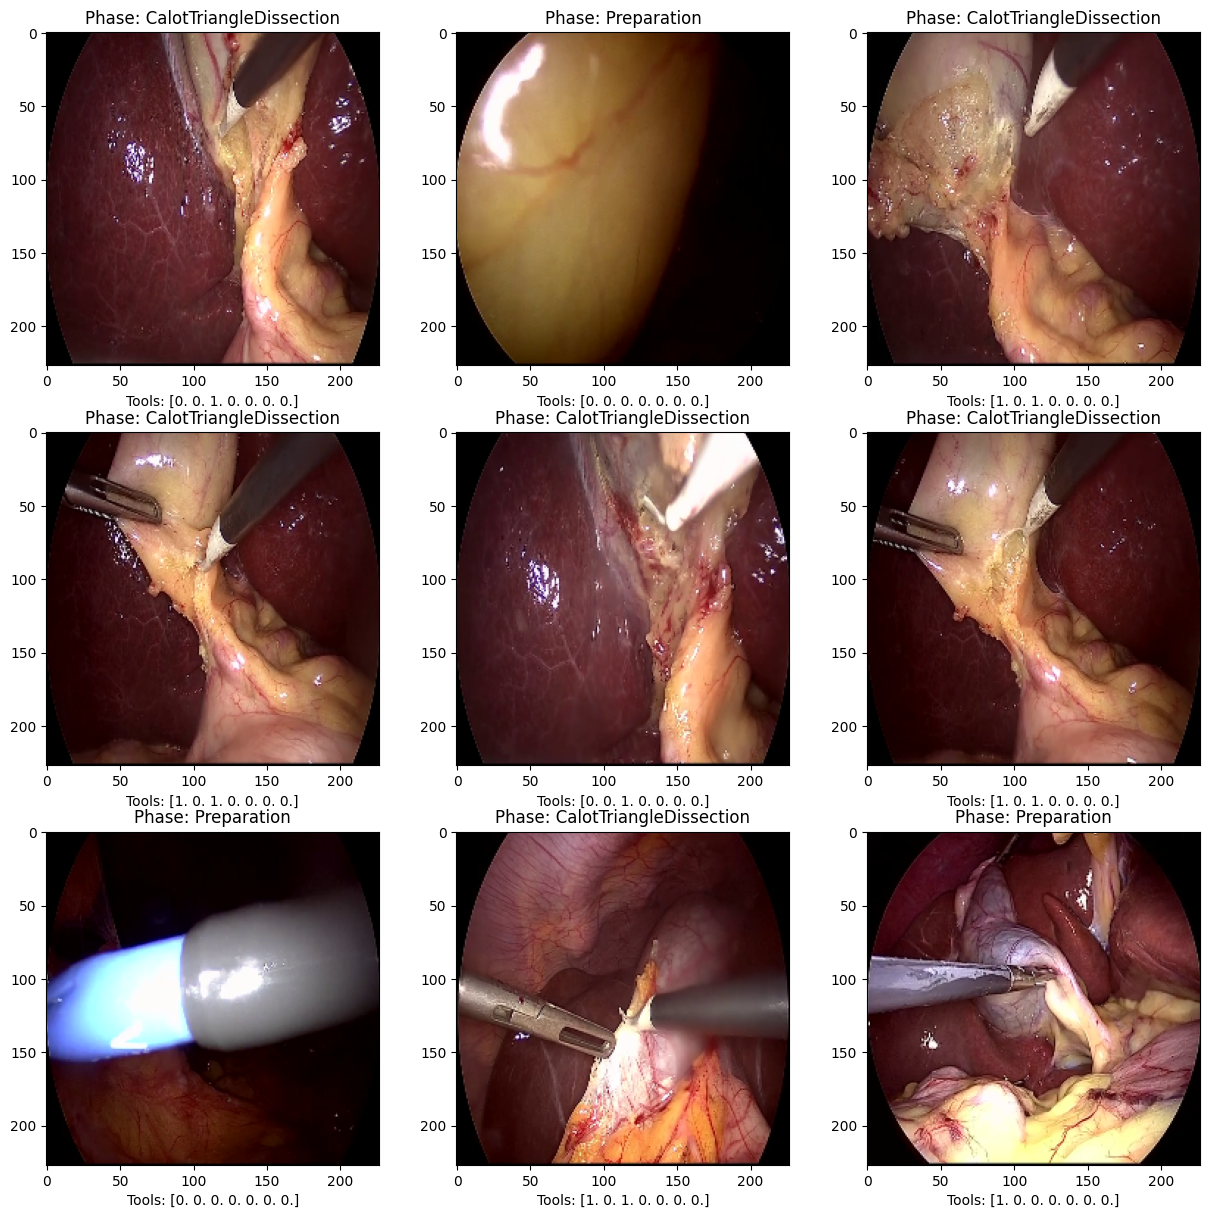

In [152]:
plt.figure(figsize=(15, 15), dpi=100)

figureIndex = 0
for dataSample in vanillaDataset.shuffle(1000).take(9):
    frame = dataSample['frame']
    toolsTarget = dataSample['toolsTarget']
    phaseTarget = dataSample['phaseTarget']
    
    ax = plt.subplot(3, 3, figureIndex + 1)
    figureIndex += 1
    
    frameImage = tf.keras.preprocessing.image.array_to_img(frame)
#     plt.imshow(frameImage * 255.0)
    plt.imshow(frameImage)    
    plt.title("Phase: {}".format(labelToPhaseDecoding[phaseTarget.numpy()]))
    plt.xlabel("Tools: {}".format(toolsTarget))

#### 3.4.2.4 General Statistics

Retrieve targets:

In [153]:
yToolsTargets = np.array([ sample['toolsTarget'].numpy() for sample in iter(vanillaDataset) ])
yPhaseTargets = np.array([ sample['phaseTarget'].numpy() for sample in iter(vanillaDataset) ])

Display counts for Phases:

In [154]:
def printTargetCounts(y, label, axis=0):
    _, yCounts = np.unique(y, return_counts=True, axis=axis)
    
    yTotal = len(y)
    
    header = "{0:5s} | Total={1:5d} \n".format(label, yTotal)
    content = ""
    percentages = yCounts / yTotal * 100.0
    
    for i in range(7):
        content = content + ("{0:1} | {1:23s} | {2:5} Counts, {3:.2f}% \n".format(i, labelToPhaseDecoding[i], yCounts[i], percentages[i]))
    
    print(header)
    print(content)
    
    fig, ax = plt.subplots()
    
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Samples')
    ax.set_ylabel('Phases')
    ax.set_title('Phases Statistics')
    
    hbars = ax.barh(list(labelToPhaseDecoding.values()), yCounts, xerr=percentages, align='center')
    ax.bar_label(hbars, labels=['±%.2f' % c for c in percentages],
             padding=8, color='black', fontsize=14)
    ax.set_xlim(right=15000)
    
    plt.show()

Phases | Total=31157 

0 | Preparation             |  2133 Counts, 6.85% 
1 | CalotTriangleDissection | 12123 Counts, 38.91% 
2 | ClippingCutting         |  2711 Counts, 8.70% 
3 | GallbladderDissection   |  7831 Counts, 25.13% 
4 | GallbladderPackaging    |  1676 Counts, 5.38% 
5 | CleaningCoagulation     |  2646 Counts, 8.49% 
6 | GallbladderRetraction   |  2037 Counts, 6.54% 



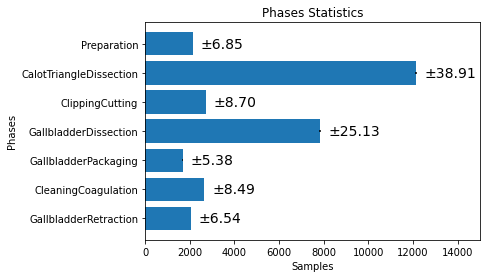

In [156]:
printTargetCounts(yPhaseTargets, "Phases")

Original distribution of dataset from EndoNet paper:

<img src="images/PhasesDistribution.png" alt="Phases Distribution" class="bg-primary" width="600px">
<center>Phases Distribution for entire datset.</center>

## 3.5 Loading Training and Validation data

Read records for videos

In [157]:
trainDataset, valDataset = dataGenerator.readTFRecordsForTraining(videosIds)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Check dataset specifications

In [158]:
trainDataset.element_spec

(TensorSpec(shape=(227, 227, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(7,), dtype=tf.float32, name=None),
 TensorSpec(shape=(7,), dtype=tf.float32, name=None))

In [159]:
valDataset.element_spec

(TensorSpec(shape=(227, 227, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(7,), dtype=tf.float32, name=None),
 TensorSpec(shape=(7,), dtype=tf.float32, name=None))

In [160]:
print("\nShapes")
print(trainDataset)
print(valDataset)

print("\nLength")
print("Training Size: {}".format(len(np.array([ sample[1].numpy() for sample in iter(trainDataset) ]))))
print("Validation Size: {}".format(len(np.array([ sample[1].numpy() for sample in iter(valDataset) ]))))


Shapes
<ParallelMapDataset shapes: ((227, 227, 3), (7,), (7,)), types: (tf.float32, tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((227, 227, 3), (7,), (7,)), types: (tf.float32, tf.float32, tf.float32)>

Length
Training Size: 21809
Validation Size: 9348


# 4. Model | AlexNet 
## 4.1 Key Components

### 4.1.1 Rectified Linear Units (ReLUs)

$f(x) = max(0, x)$

A **non-saturating nonlinear** activation function.

* Non-saturation: $|lim_{z \rightarrow +\infty}| f(z) = +\infty$

* Function Plot:
![RELU](images/RELU.png)

Benefits:
1. Compared with $tanh(x)$ it does not involve exponentiation operation which results in **faster training**.
2. Reduces **vanishing gradient** effect.
3. Does not require **input normalization** to prevent saturation.

Risks:
1. Can lead to **dying neurons**.

### 4.1.2 Inter-Channel Local Response Normalization

Square-normalizing the pixel values in a feature map within a local neighborhood. Uses a **non-trainable** layer.

<center> $b^i_{x,y}  = a^i_{x,y} / \Bigg( k + \alpha \sum\limits_{j=max(0, i-n/2)}^{min(N-1, i+n/2)} (a^j_{x,y})^2 \Bigg)^\beta$ </center>

where: 
* $a^i_{x, y}$ - activity of neuron computed by applying kernel $i$ at position $(x, y)$ and then ReLU activation.
* $N$ - total number of kernels.
* Hyperparameters:
    * $k$ - avoids singularities (division by zero)
    * $\alpha$ - normalization constant
    * $\beta$ - contrasting constant
    * $n$ - defining neighborhood length (how many consecutive pixel values need to be considered while carrying out the normalization)
    

<img src="images/InterLRN.png" alt="Inter-Channel Local Response Normalization" class="bg-primary" width="600px">
<center>Visual example for n=2 and N=4. [<a href=https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac target="_blank">Source</a>]</center>

Benefits:

1. Empirical results show that it **aids generalization**, reducing error rates. 
2. Limiting **vanishing gradient** from unbounded activation.
3. Encouraging **lateral inhibition** by carrying out local contrast enhancement: locally maximum pixel values are used as excitation for the next layers.

Original AlexNet uses $k=2, n=5, \alpha=10^{-4}, \beta=0.75$

In [162]:
class LocalResponseNormalization(Layer):
    def __init__(self, depth_radius=2, bias=1.0, alpha=2e-05, beta=0.75, name='LRN', **kwargs):
        super(LocalResponseNormalization, self).__init__(name=name, **kwargs)
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta
        
    def call(self, inputs):
        return tf.nn.local_response_normalization(inputs, 
                                                  depth_radius=self.depth_radius, 
                                                  bias=self.bias,
                                                  alpha=self.alpha,
                                                  beta=self.beta,
                                                  name=self.name)
    
    def get_config(self):
        # Overriding for saving layer capabilities
        config = super().get_config().copy()
        config.update({
            'depth_radius': self.depth_radius,
            'bias': self.bias,
            'alpha': self.alpha,
            'beta': self.beta
        })
        return config    

### 4.1.3. Overlapping Pooling

A pooling layer is a grid of pooling units spaced $s$ pixels apart, each sumarizing a neighborhood of size $z \times z$ centered at the location of the pooling unit. Setting $s=2 < z=3$ to obtain overlapping pooling.

Benefits
* Reducing error rate
* Slightly more difficult to overfit

### 4.1.4 Dropout

Combining predictions of multiple models is very succesful to reduce test errors, but expensive to train. Efficient way for model combination that costs a factor of two during training.

For every input the model samples a different architecture, neurons being forced to learn more robust features, therefore reducing complex co-adaptations.

Benefits:

* Reducing overfitting

### 4.1.5 Calculating Outputs & Parameters

For $I$ - input size, $K$ - kernel size, $P$ - padding size, $S$ - stride size, $F$ - number/depth of filters/feature, $L$ - current layer, $L-1$ - previous layer, $n$ - number of units.

#### Convolution 2D
$ convOutput = \frac{I - K + 2 * P}{S} + 1 \times F$ 

$oneCubeParameters = K * K * {F}^{[L - 1]} + 1$

$convParameters = oneCubeParameters * {F}^{[L]} = (K * K * {F}^{[L - 1]} + 1) * {F}^{[L]}$

#### Pooling Output
$ poolOutput = \frac{I - K}{S} + 1 \times F$ 

No additional parameters

#### Fully Connected 
$ W^{[L]}: (n^{[L]}, n^{[L-1]})$

$ b^{[L]}: (n^{[L]}, 1)$

$fullyConnectedParames = n^{[L]} * n^{[L-1]} + n^{[L]}$

#### Padding Formula
$P = ((S - 1) * I - S + K)/2$



## 4.2 Architecture

### 4.2.1 High Level View

<img src="images/AlexNet.png" alt="AlexNet Architecture" class="bg-primary" width="600px">
<center>AlexNet Architecture</center>

<img src="images/AlexNetDetailed.png" alt="AlexNet Detailed Architecture" class="bg-primary" width="600px">
<center>AlexNet Detailed Architecture</center>

### 4.2.2 Model Sequential

In [163]:
class AlexNetSequential(Sequential):
    def __init__(self, input_shape, weightsFile='pretrained_weights/alexnet.npy', name="AlexNetSequential"):
        super(AlexNetSequential, self).__init__(name=name)
        
        self.weightsPath = weightsFile
        self.weightsInitializer = tf.keras.initializers.Zeros()
        
        # 1. 1st Layer: Conv -> Relu -> LRN -> MaxPool
        # 1.1 ConvOutput =  (227 - 11 + 2 * 0) / 4 + 1 = 55 |> (55, 55, 96)
        # 1.2 Parameters = (11 * 11 * 3 + 1) * 96 = 34,944
        self.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', name='conv1', input_shape=input_shape, kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu1'))
        self.add(LocalResponseNormalization(depth_radius=2, bias=1.0, alpha=2e-5, beta=0.75, name="norm1"))
        # 1.3 MaxOutput =  (55 - 3) / 2 + 1 = 27 |> (27, 27, 96)
        self.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1'))
        
        # 2. 2nd Layer: Conv -> Relu -> LRN -> MaxPool (2 groups) 
        # 2.1 Padding = ((1 - 1) * 27 - 1 + 5)/2 = 2
        # 2.2 ConvOutput =  (27 - 5 + 2 * 2) / 1 + 1 = 27 |> (27, 27, 256)
        # 2.3 Parameters = (5 * 5 * 96 + 1) * 256 = 614,656
        self.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), groups=1, padding='same', name='conv2', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu2'))
        self.add(LocalResponseNormalization(depth_radius=2, bias=1.0, alpha=2e-5, beta=0.75, name="norm2"))
        # 2.4 MaxOutput =  (27 - 3) / 2 + 1 = 13 |> (13, 13, 256)
        self.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool2'))
        
        # 3. 3rd Layer: Conv -> Relu
        # 3.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 3.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 384)
        # 3.3 Parameters = (3 * 3 * 256 + 1) * 384 = 885,120
        self.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv3', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu3'))
        
        # 4. 4th Layer: Conv -> Relu (2 groups)
        # 4.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 4.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 384)
        # 4.3 Parameters = (3 * 3 * 384 + 1) * 384 = 1,327,488
        self.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), groups=1, padding='same', name='conv4', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu4'))
        
        # 5. 5th Layer: Conv -> Relu -> MaxPool (2 groups)
        # 5.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 5.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 256)
        # 5.3 Parameters = (3 * 3 * 384 + 1) * 256 = 884,992
        self.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), groups=1, padding='same', name='conv5', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu5'))
        # 5.2 MaxOutput =  (13 - 3) / 2 + 1 = 6 |> (6, 6, 256)
        self.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool5'))
        
        # FlattenOutput = 6 * 6 * 256 = 9,216
        self.add(Flatten())
        
        # 6. 6th Layer: FC -> Relu -> Dropout
        # Parameters = 4,096 * 9,216 + 4,096 = 37,752,832
        self.add(Dense(4096, name='fc6', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu6'))
        self.add(Dropout(0.5, name='dropout6'))
        
        # 7. 7th Layer: FC -> Relu -> Dropout
        # Parameters = 4,096 * 4,096 + 4,096 = 16,781,312
        self.add(Dense(4096, name='fc7', kernel_initializer=self.weightsInitializer))
        self.add(Activation('relu', name='relu7'))
        self.add(Dropout(0.5, name='dropout7'))
        
        # Total Parameters = 34,944 + 614,656 + 885,120 + 1,327,488 + 884,992 + 37,752,832 + 16,781,312 = 58,281,344 
    
    def readWeights(self):
        self.preloadedWeights = np.load(self.weightsPath, allow_pickle=True, encoding='latin1').item()
        
        print('Preloaded Conv1: {}'.format(self.preloadedWeights['conv1'][0].shape))
        print('Network Conv1: {}'.format(11 * 11 * 3 * 96 + 96))

        print('Preloaded Conv2: {}'.format(self.preloadedWeights['conv2'][0].shape))
        print('Network Conv2: {}'.format((5 * 5 * 48 * 256) * 2 + 256))

        print('Preloaded Conv3: {}'.format(self.preloadedWeights['conv3'][0].shape))
        print('Network Conv3: {}'.format((3 * 3 * 256 * 384) + 384))

        print('Preloaded Conv4: {}'.format(self.preloadedWeights['conv4'][0].shape))
        print('Network Conv4: {}'.format((3 * 3 * 192 * 384) * 2 + 384))

        print('Preloaded Conv5: {}'.format(self.preloadedWeights['conv5'][0].shape))
        print('Network Conv5: {}'.format((3 * 3 * 192 * 256) * 2 + 256))

        print('Preloaded FC6: {}'.format(self.preloadedWeights['fc6'][0].shape))
        print('Network FC6: {}'.format(9216 * 4096 + 4096))

        print('Preloaded FC7: {}'.format(self.preloadedWeights['fc7'][0].shape))
        print('Network FC7: {}'.format(4096 * 4096 + 4096))
        
    def __transformWeights(self, layerName):
        '''Original Alex net weights that we have loaded have been trained on two GPUs with two convolutional
        groupings for Conv2, Conv4 and Conv5. Therefore we need to duplicate those weights to make them work 
        with one group convolutions.'''
        
        # Store for further reallocation of W matrices, while bias will stay the same
        convWeights = self.preloadedWeights[layerName]
        
        # Get W matrices
        convWeightsTwoGroups_W = self.preloadedWeights[layerName][0]
        
        # Duplicate them
        convWeightsOneGroup_W = np.concatenate((convWeightsTwoGroups_W, convWeightsTwoGroups_W), axis=2)
        
        # Store them in original weights W
        convWeights[0] = convWeightsOneGroup_W
        
        return convWeights
        
    def setWeights(self):
        self.get_layer(name='conv1').set_weights(self.preloadedWeights['conv1'])
        self.get_layer(name='conv2').set_weights(self.__transformWeights('conv2'))
        self.get_layer(name='conv3').set_weights(self.preloadedWeights['conv3'])
        self.get_layer(name='conv4').set_weights(self.__transformWeights('conv4'))
        self.get_layer(name='conv5').set_weights(self.__transformWeights('conv5'))
        self.get_layer(name='fc6').set_weights(self.preloadedWeights['fc6'])
        self.get_layer(name='fc7').set_weights(self.preloadedWeights['fc7'])    
    
    def loadWeights(self):
        self.readWeights()
        self.setWeights()

### 4.2.3 Build Sequential Model

Create uncompiled model:

In [164]:
alexNetSequential = AlexNetSequential(input_shape=(227, 227, 3))

Load pre-trained weights from [Caffe](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet) and converted using [Caffee-tensorflow](https://github.com/ethereon/caffe-tensorflow):

In [166]:
alexNetSequential.loadWeights()

Preloaded Conv1: (11, 11, 3, 96)
Network Conv1: 34944
Preloaded Conv2: (5, 5, 48, 256)
Network Conv2: 614656
Preloaded Conv3: (3, 3, 256, 384)
Network Conv3: 885120
Preloaded Conv4: (3, 3, 192, 384)
Network Conv4: 1327488
Preloaded Conv5: (3, 3, 192, 256)
Network Conv5: 884992
Preloaded FC6: (9216, 4096)
Network FC6: 37752832
Preloaded FC7: (4096, 4096)
Network FC7: 16781312


Check weights of one layer:

In [167]:
alexNetSequential.layers[4].weights

[<tf.Variable 'conv2/kernel:0' shape=(5, 5, 96, 256) dtype=float32, numpy=
 array([[[[-1.47258425e-02, -2.38404032e-02, -1.87015180e-02, ...,
            6.57436391e-03,  1.28610083e-03, -7.62453023e-03],
          [ 9.96324979e-03,  2.12005563e-02, -4.51514274e-02, ...,
            2.00431868e-02,  9.12814774e-03, -1.02854287e-02],
          [-8.77500232e-03, -1.01256398e-02,  5.44402562e-03, ...,
            1.68249626e-02,  8.71526916e-03, -7.12395553e-03],
          ...,
          [ 1.11368438e-02, -1.50128379e-02, -3.03194020e-03, ...,
           -7.44373584e-03,  1.21244062e-02, -1.43434794e-03],
          [-1.58353206e-02, -4.85492405e-03, -9.35518276e-03, ...,
           -2.83697005e-02, -1.02551952e-02, -6.64326269e-03],
          [-6.58801990e-03, -1.90736577e-02,  1.76857710e-02, ...,
            3.43685877e-03,  2.55440711e-03, -4.33045905e-03]],
 
         [[-1.96738448e-02, -1.20470757e-02, -3.10218986e-02, ...,
           -3.23055387e-02,  6.40826160e-03, -7.53955403e-03

Print weights summary:

In [168]:
print("Weights:", len(alexNetSequential.weights))
print("Trainable Weights:", len(alexNetSequential.trainable_weights))
print("Non Trainable Weights:", len(alexNetSequential.non_trainable_weights))

Weights: 14
Trainable Weights: 14
Non Trainable Weights: 0


Check model summary:

In [169]:
alexNetSequential.summary()    

Model: "AlexNetSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
relu1 (Activation)           (None, 55, 55, 96)        0         
_________________________________________________________________
norm1 (LocalResponseNormaliz (None, 55, 55, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
relu2 (Activation)           (None, 27, 27, 256)       0         
_________________________________________________________________
norm2 (LocalResponseNormaliz (None, 27, 27, 256) 

Create model graph

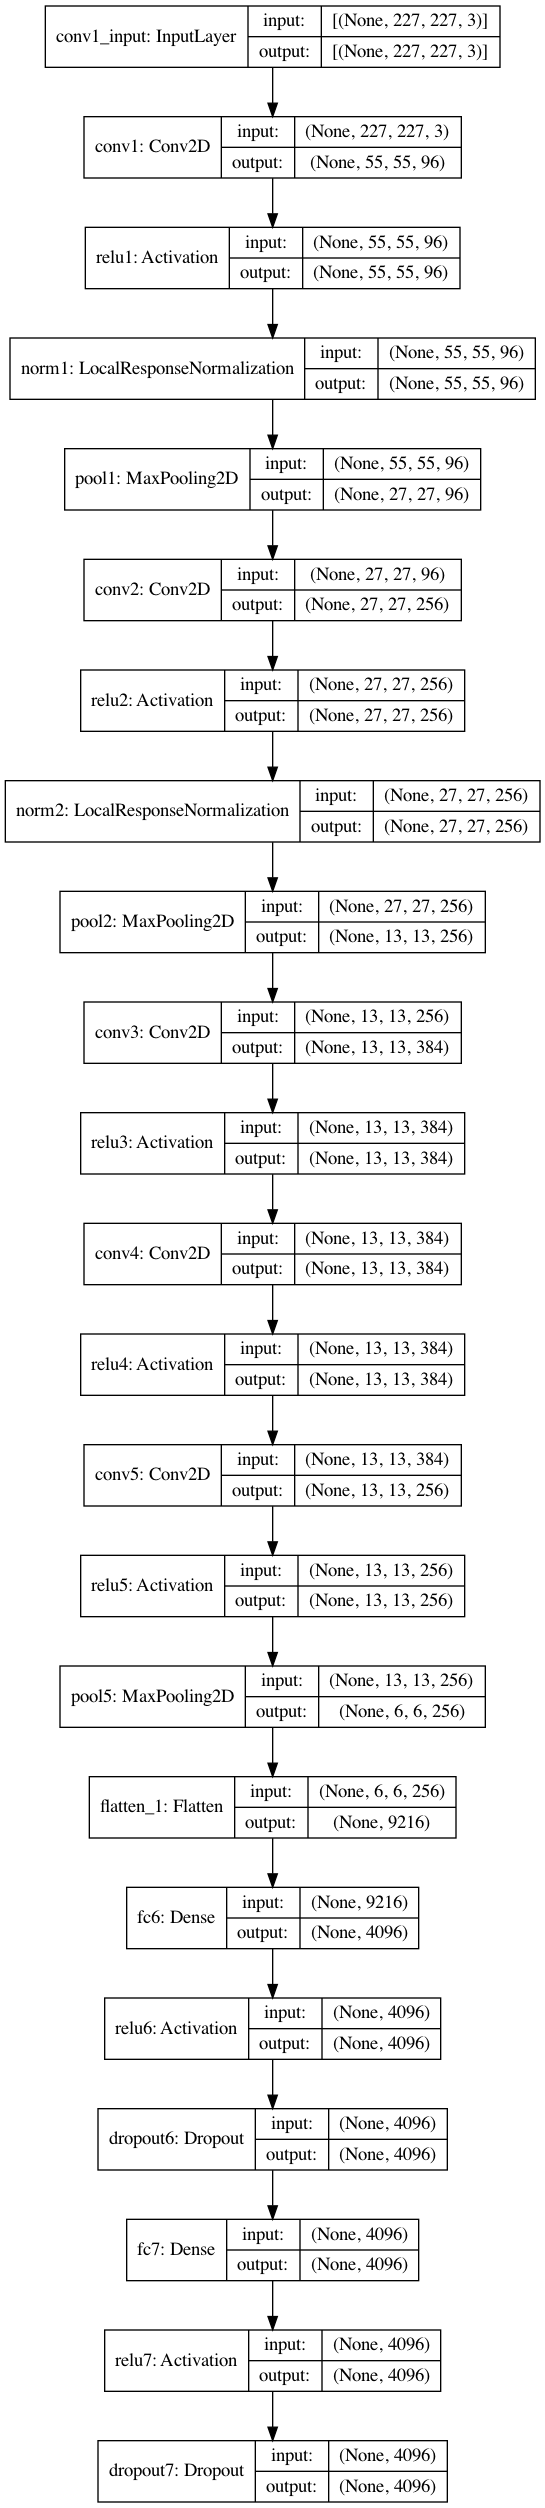

In [170]:
dot_img_file = 'architectures/alexNetSequential.png'
tf.keras.utils.plot_model(alexNetSequential, to_file=dot_img_file, show_shapes=True)

# 5. Model | EndoNet

## 5.1 Architecture

<img src="images/EndoNet.png" alt="EndoNet Architecture" class="bg-primary" width="800px">
<center>EndoNet Architecture</center>

## 5.2 Components

### 5.2.1 Tools Loss: Multi Label Binary Crossentropy 

<img src="images/MultiLabelBinarryCrossentropy.png" alt="Multi Label Binary Crossentropy" class="bg-primary" width="500px">
<center>Multi Label Binary Crossentropy</center>

In [172]:
class MultiLabelBinaryCrossentropy(Loss):
    def __init__(self, alpha=1, e=1e-9, name="MultiLabelBinaryCrossentropy"):
        super().__init__(name=name)
        self.alpha = alpha
        self.e = e
        self.scaleFactor = 10

    def call(self, yTrue, yPred):   
        
        sigmoids = sigmoid(yPred)
        
        # Avoiding log(0)
        predictionProbability = log(sigmoids + self.e)
        predictionComplement = log(1 - sigmoids + self.e)
        
        targetProbability = yTrue
        targetComplement = 1 - yTrue 
        
        spreadTotal = (targetProbability * predictionProbability) + (targetComplement * predictionComplement)

        crossEntropy = reduce_mean(spreadTotal, name=self.name)
        
        return self.alpha * -crossEntropy * self.scaleFactor

### 5.2.2 Phase Loss: Softmax Multinomial Logistic Function

<img src="images/SoftmaxMultinomialLogisticFunction.png" alt="Softmax Multinomial Logistic Function" class="bg-primary" width="300px">
<center>Softmax Multinomial Logistic Function</center>

In [173]:
class SoftmaxMultinomialLogisticFunction(Loss):
    def __init__(self, beta=1, e=1e-9, name="SoftmaxMultinomialLogisticFunction"):
        super().__init__(name=name)
        self.beta = beta
        self.e = e
        self.scaleFactor = 10

    def call(self, yTrue, yPred):
        
        softmaxResult = softmax(yPred)

        # Avoiding log(0)
        predictionProbability = log(softmaxResult + self.e)
        
        targetProbability = yTrue
        
        spreadTotal = targetProbability * predictionProbability
         
        mean = reduce_mean(spreadTotal, name=self.name)
        
        return self.beta * -mean * self.scaleFactor

## 5.3 Implementation

### 5.3.1 SummaryWriter

Responsible for writing summaries that will be displayed with Tensorboard.

In [175]:
class SummaryWriter():
    
    def __init__(self, model, baseDir='tensorboard/logs/gradient_tape'):
        self.baseDir = baseDir
        self.trainDir = 'train'
        self.validationDir = 'validation'
        self.imagesDir = 'images'
        
        self.setupSummaryWriters()
        
#         self.callbackTensorBoard = tf.keras.callbacks.TensorBoard(self.baseDir)
#         self.callbackTensorBoard.set_model(model)
#         tf.summary.trace_on(graph=True, profiler=True)   
        
    def setupSummaryWriters(self):
        '''Standard summary creation flow with directories for each'''
        
        currentTime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
        trainLogDir = "{}/{}/{}".format(self.baseDir, currentTime, self.trainDir)
        validationLogDir =  "{}/{}/{}".format(self.baseDir, currentTime, self.validationDir)
        imageLogDir =  "{}/{}/{}".format(self.baseDir, currentTime, self.imagesDir)        

        self.trainSummaryWriter = tf.summary.create_file_writer(trainLogDir)
        self.validationSummaryWriter = tf.summary.create_file_writer(validationLogDir)
        self.imagesSummaryWriter = tf.summary.create_file_writer(imageLogDir)        
        
    def writeTrainSummary(self, name, result, step):
        with self.trainSummaryWriter.as_default():
            tf.summary.scalar(name, result, step=step) 
            
#         self.traceExport(step)
            
    def writeValidationSummary(self, name, result, step):
        with self.validationSummaryWriter.as_default():
            tf.summary.scalar(name, result, step=step)      
            
    def writeConfusionMatrix(self, epoch, confusionMatrixImage):
        # Log the confusion matrix as an image summary.
        with self.imagesSummaryWriter.as_default():
            tf.summary.image("Confusion Matrix", confusionMatrixImage, step=epoch)
            
    def traceExport(self, epoch):
        with self.trainSummaryWriter.as_default():
            tf.summary.trace_export(name="autograph", step=epoch, profiler_outdir=self.baseDir) 

### 5.3.2 Confusion Matrix

In [176]:
class ConfusionMatrixGenerator():
    '''Adapted from https://www.tensorflow.org/tensorboard/image_summaries'''
    
    def __init__(self):
        self.labelToPhaseDecoding = {
            0: "Preparation",
            1: "CalotTriangleDissection",
            2: "ClippingCutting",
            3: "GallbladderDissection",
            4: "GallbladderPackaging",
            5: "CleaningCoagulation",
            6: "GallbladderRetraction",
        }    
        
    def plotConfusionMatrix(self, cm, classNames):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        classNames (array, shape = [n]): String names of the integer classes
        """

        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classNames))
        plt.xticks(tick_marks, classNames, rotation=45)
        plt.yticks(tick_marks, classNames)

        # Compute the labels from the normalized confusion matrix.
        labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        return figure        

    def plotToImage(self, figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')

        # Closing the figure prevents it from being displayed directly inside the notebook.
        plt.close(figure)
        buf.seek(0)
        
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        
        return image    

    def generateConfusionMatrix(self, yValidationOneHot, yPredictOneHot):
        # Retrieve predicted classes
        yPred = np.argmax(yPredictOneHot, axis=1)
        yValidation = np.argmax(yValidationOneHot, axis=1)   
    
        # Calculate the confusion matrix.
        confusionMatrix = confusion_matrix(yValidation, yPred)

        # Log the confusion matrix as an image summary.
        figure = self.plotConfusionMatrix(confusionMatrix, classNames=list(self.labelToPhaseDecoding.values()))
        cm_image = self.plotToImage(figure)

        return cm_image

### 5.3.3 EndoNetMetrics
Creating, updating, reseting, and printing metrics for validation and training.

In [177]:
class EndoNetMetrics():
    '''Creating, updating, reseting, and printing metrics for validation and training.'''
    
    def __init__(self, model):
        self.writer = SummaryWriter(model=model) 
        self.cmGenerator = ConfusionMatrixGenerator()
        
    def __configureTrainingToolsMetrics(self):
        self.trainingToolsAUC = tf.keras.metrics.AUC(name="Training Tools AUC")
        self.trainingToolsAccuracy = tf.keras.metrics.Accuracy(name="Training Tools Accuracy")
        self.trainingToolsPrecision = tf.keras.metrics.Precision(name="Training Tools Precision")
        self.trainingToolsRecall = tf.keras.metrics.Recall(name="Training Tools Recall")   
        
        self.trainingToolsMetrics = [self.trainingToolsAUC, 
                                     self.trainingToolsAccuracy, 
                                     self.trainingToolsPrecision,
                                     self.trainingToolsRecall]   
        
    def __configureTrainingPhaseMetrics(self):
        self.trainingPhaseAUC = tf.keras.metrics.AUC(name="Training Phase AUC")
        self.trainingPhaseAccuracy = tf.keras.metrics.Accuracy(name="Training Phase Accuracy")  
        self.trainingPhasePrecision = tf.keras.metrics.Precision(name="Training Phase Precision")    
        self.trainingPhaseRecall = tf.keras.metrics.Recall(name="Training Phase Recall")
        
        self.trainingPhaseMetrics = [self.trainingPhaseAUC, 
                                     self.trainingPhaseAccuracy, 
                                     self.trainingPhasePrecision,
                                     self.trainingPhaseRecall]   
                
    def __configureTrainingLossMetrics(self):
        self.trainingToolsLoss = tf.keras.metrics.Mean('Train Tool Loss', dtype=tf.float32)
        self.trainingPhaseLoss = tf.keras.metrics.Mean('Train Phase Loss', dtype=tf.float32)
        self.trainTotalLoss = tf.keras.metrics.Mean('Train Total Loss', dtype=tf.float32)
        self.trainStepTotalLoss = tf.keras.metrics.Mean('Train Step Loss', dtype=tf.float32)

    def __configureLearningRateMetrics(self):
        self.alexNetLearningRateMetric = tf.keras.metrics.Mean('AlexNet Learning Rate', dtype=tf.float32)  
        self.endoNetLearningRateMetric = tf.keras.metrics.Mean('EndoNet Learning Rate', dtype=tf.float32)  
        
    def __configureValidationToolsMetrics(self):
        self.validationToolsAUC = tf.keras.metrics.AUC(name="Validation Tools AUC")
        self.validationToolsAccuracy = tf.keras.metrics.Accuracy(name="Validation Tools Accuracy")       
        self.validationToolsPrecision = tf.keras.metrics.Precision(name="Validation Tools Precision")    
        self.validationToolsRecall = tf.keras.metrics.Recall(name="Validation Tools Recall")            

        self.validationToolsMetrics = [self.validationToolsAUC, 
                                     self.validationToolsAccuracy, 
                                     self.validationToolsPrecision,
                                     self.validationToolsRecall]    
        
    def __configureValidationPhaseMetrics(self):
        self.validationPhaseAUC = tf.keras.metrics.AUC(name="Validation Phase AUC")
        self.validationPhaseAccuracy = tf.keras.metrics.Accuracy(name="Validation Phase Accuracy")       
        self.validationPhasePrecision = tf.keras.metrics.Precision(name="Validation Phase Precision")    
        self.validationPhaseRecall = tf.keras.metrics.Recall(name="Validation Phase Recall")            
        
        self.validationPhaseMetrics = [self.validationPhaseAUC, 
                                     self.validationPhaseAccuracy, 
                                     self.validationPhasePrecision,
                                     self.validationPhaseRecall]     
        
    def __configureValidationLossMetrics(self):
        self.validationToolsLoss = tf.keras.metrics.Mean('Validation Tool Loss', dtype=tf.float32)
        self.validationPhaseLoss = tf.keras.metrics.Mean('Validation Phase Loss', dtype=tf.float32)
        self.validationTotalLoss = tf.keras.metrics.Mean('Validation Total Loss', dtype=tf.float32)          
        
    def __configureValidationMetrics(self):
        self.__configureValidationToolsMetrics()
        self.__configureValidationPhaseMetrics()
        self.__configureValidationLossMetrics()
        
    def __configureTrainingMetrics(self):
        self.__configureTrainingToolsMetrics()
        self.__configureTrainingPhaseMetrics()
        self.__configureTrainingLossMetrics()  
        self.__configureLearningRateMetrics()
    
    def configureMetrics(self):
        self.__configureTrainingMetrics()
        self.__configureValidationMetrics()      
        
    def __updateMetrics(self, toolsMetrics, phaseMetrics, toolsTruth, toolsLogits, phaseTruth, phaseLogits):
        # Update tools training metrics.
        for metric in toolsMetrics:
            metric.update_state(toolsTruth, toolsLogits)

        # Update phase training metrics.
        for metric in phaseMetrics:
            metric.update_state(phaseTruth, phaseLogits)           
            
    def __displayAndResetMetrics(self, epoch, toolsMetrics, metricName, summaryWriter):
        # Display tools training metrics.
        for metric in toolsMetrics:
            # Display metrics at the end of each epoch.
            print("{} | {} | {:.4f}".format(metric.name, metricName, float(metric.result())))
            
            summaryWriter(metric.name, metric.result(), epoch)
                
            # Reset training metrics at the end of each epoch
            metric.reset_states()       
        
    def displayAndResetValidationMetrics(self, epoch):
        self.__displayAndResetMetrics(epoch, self.validationToolsMetrics, 
                                      'Tools', self.writer.writeValidationSummary)
        
        self.__displayAndResetMetrics(epoch, self.validationPhaseMetrics, 
                                      'Phase', self.writer.writeValidationSummary)        
            
    def displayAndResetTrainingMetrics(self, epoch):
        self.__displayAndResetMetrics(epoch, self.trainingToolsMetrics, 
                                      'Tools', self.writer.writeTrainSummary)        
        self.__displayAndResetMetrics(epoch, self.trainingPhaseMetrics, 
                                      'Phase', self.writer.writeTrainSummary)           
        
    def updateValidationMetrics(self, toolsTruth, toolsLogits, phaseTruth, phaseLogits):
        self.__updateMetrics(self.validationToolsMetrics, 
                           self.validationPhaseMetrics,
                           toolsTruth,
                           sigmoid(toolsLogits),
                           phaseTruth,
                           softmax(phaseLogits))
        
    def updateTrainingMetrics(self, toolsTruth, toolsLogits, phaseTruth, phaseLogits):
        self.__updateMetrics(self.trainingToolsMetrics, 
                           self.trainingPhaseMetrics,
                           toolsTruth,
                           sigmoid(toolsLogits),
                           phaseTruth,
                           softmax(phaseLogits))        
        
    def updateValidationLosses(self, toolLoss, phaseLoss, totalLoss):
        self.validationToolsLoss(toolLoss)
        self.validationPhaseLoss(phaseLoss)
        self.validationTotalLoss(totalLoss)     
        
    def updateTrainingLosses(self, toolLoss, phaseLoss, totalLoss):
        self.trainingToolsLoss(toolLoss)
        self.trainingPhaseLoss(phaseLoss)
        self.trainTotalLoss(totalLoss)    
        
    def updateTrainStepTotalLoss(self, totalLoss, epoch):         
        self.writer.writeTrainSummary(self.trainTotalLoss.name, self.trainTotalLoss.result(), epoch)
            
    def updateLearningRates(self, lr1, lr2, epoch):
        self.alexNetLearningRateMetric(lr1)
        self.endoNetLearningRateMetric(lr2)       
        
        self.writer.writeTrainSummary(self.alexNetLearningRateMetric.name, 
                                      self.alexNetLearningRateMetric.result(), epoch)
        self.writer.writeTrainSummary(self.endoNetLearningRateMetric.name, 
                                      self.endoNetLearningRateMetric.result(), epoch)   
        
    def logConfusionMatrix(self, epoch, yValidationOneHot, yPredictOneHot):
        confusionMatrixImage = self.cmGenerator.generateConfusionMatrix(yValidationOneHot, yPredictOneHot)
        
        self.writer.writeConfusionMatrix(epoch, confusionMatrixImage)

### 5.3.4 Model Writer
Saving and loading models and/or their weights. Managing entire checkpoint cycle.

In [178]:
class ModelWriter():
    '''Saving and loading models and/or their weights. Managing entire checkpoint cycle.'''
    
    def __init__(self, patience=5, weightsDir='weights', modelsDir='models'):
        self.bestLoss = float('inf')
        # Number of epochs to wait for improvements before stopping training
        self.patience = patience
        self.bestWeights = None
        self.weightsDir = weightsDir
        self.modelsDir = modelsDir   
        self.bestEpoch = 0
        
    def saveModel(self, model, epoch, currentLoss, modelFileName):
        # 1. Save model
        tf.saved_model.save(model, "{}/{}".format(self.modelsDir, modelFileName))
        
        # 2. Save model weights
        model.save_weights("{}/{}".format(self.weightsDir, modelFileName))        
            
    def saveIfBest(self, model, epoch, currentLoss, modelFileName='best'):
        
        # 1. Check if new best model
        newBestModel = np.less(currentLoss, self.bestLoss)
        
        if newBestModel:
            self.bestLoss = currentLoss
            
            # Reset waiting cycle
            self.wait = 0
            
            # Record best weights and save model
            self.bestWeights = model.get_weights()
            self.bestEpoch = epoch
            print("\n>>>> Saving New Best Model with Loss: {} at Epoch: {}".format(currentLoss, epoch))
            
            self.saveModel(model, epoch, currentLoss, modelFileName)
            
            # Training should continue
            return False
        else:
            # Increment waiting cycle
            self.wait += 1
            # Check if we sould still wait
            waitingDone = self.wait >= self.patience

            if waitingDone:
                # Record stopped weights and save model
                print("\n>>>> Saving Stopped Model with Loss: {} at Epoch: {}".format(currentLoss, epoch))
                
                self.saveModel(model, epoch, currentLoss, 'stopped')
                # Training should stop
                return True
            else:
                # We can still wait. Training should continue
                return False
            
    def loadModel(self, modelFileName):
        
        loadedModel = tf.saved_model.load("{}/{}".format(self.modelsDir, modelFileName))
        
        # Retrieve trainable variables
        print("\n\n{} has {} trainable variables: {}".format(modelFileName,
                                                       len(loadedModel.trainable_variables),
                                                       ", ".join([v.name for v in loadedModel.trainable_variables])))
        
        trainableVariableIds = {id(v) for v in loadedModel.trainable_variables}
        nonTrainableVariables = [v for v in loadedModel.variables
                                   if id(v) not in trainableVariableIds]
        
        # Retrieve non-trainable variables        
        print("\n\n{} also has {} non-trainable variables: {}".format(modelFileName,
                  len(nonTrainableVariables),
                  ", ".join([v.name for v in nonTrainableVariables])))      

        return loadedModel
    
    def createCheckpoint(self, model, optimizer):
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(1), 
                                         optimizer=optimizer, 
                                         net=optimizer)

        self.checkpointManager = tf.train.CheckpointManager(self.checkpoint, "checkpoints", max_to_keep=3)
        
    def restoreCheckpoint(self):
        self.checkpoint.restore(self.checkpointManager.latest_checkpoint)
        if self.checkpointManager.latest_checkpoint:
            print("\n**** Restored from {}".format(self.checkpointManager.latest_checkpoint))
        else:
            print("\n**** No Checkpoint to restore from. Initializing from scratch...")      
            
    def processCheckpoint(self, epoch, checkpointCycle):
        '''Increment checkpoint step save new model if checkpoint cycle is met'''
        self.checkpoint.step.assign_add(1)
        
        if int(self.checkpoint.step) % checkpointCycle == 0:
            savePath = self.checkpointManager.save()
            print("\n**** Saved checkpoint for step {} in epoch {}: {}".format(int(self.checkpoint.step), epoch, savePath))

### 5.3.5 EndoNet Learning Rate Scheduler

In [179]:
class EndoNetLearningRateScheduler(LearningRateSchedule):
    '''Learning rate decay scheduler.'''
    
    def __init__(self, initialLearningRate, droptRate, decayStep):
        self.initialLearningRate = initialLearningRate
        self.dropRate = droptRate
        self.decayStep = decayStep

    def __call__(self, step):
        return self.initialLearningRate * math.pow(self.dropRate, math.floor(step / self.decayStep))  
    
    def get_config(self):
        # Overriding for saving layer capabilities
        config = super().get_config().copy()
        config.update({
            'initialLearningRate': self.initialLearningRate,
            'dropRate': self.dropRate,
            'decayStep': self.decayStep
        })
        
        return config      

### 5.3.6 EndoNet Model

In [180]:
from tensorflow.keras.layers.experimental import preprocessing

In [182]:
class EndoNet():
    def __init__(self, alexNetModel, trainData, inputShape=(227, 227, 3), patience=5, name="EndoNet"):

        self.name = name
        
        print("1. Initializing Layers")
        # 1. Storing random initializer for EndoNet layers.
        self.kernelInitializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        
        # 2. Creating EndoNet layers.
        #### Input
        self.input = tf.keras.Input(shape=inputShape)
        
        #### Normalizer
        print("2. Configuring Normalizer")        
        self.normalizer = preprocessing.Normalization()
        onlyImages = trainDataset.map(lambda frame, toolsAnnotation, phaseAnnotation: frame)
        self.normalizer.adapt(onlyImages)
        
        #### Data Augmentation
        self.randomFlip = preprocessing.RandomFlip("vertical")
        self.randomRotation = preprocessing.RandomRotation(0.1)
        self.randomZoom = preprocessing.RandomZoom(0.1)        

        #### AlexNet
        self.alexNetModel = alexNetModel
        
        #### EndoNet Layers
        self.fcTool = Dense(7, name='fcTool', kernel_initializer=self.kernelInitializer)
        self.fc8 = Concatenate(axis=1, name="fc8")
        self.fcPhase = Dense(7, name='fcPhase', kernel_initializer=self.kernelInitializer)
        
        # 3. Creating ModelWriter for model I/O operations
        print("3. Configuring ModelWriter")        
        self.io = ModelWriter()
        
        # 4. Variables for computing processing time
        self.totaTime = 0;
        self.startTime = 0;
        
        # 5. Connecting layers and instantiating model
        print("4. Building Model")        
        self.buildModel()
        
    def buildModel(self):        
        # 1. Connect layers
        normalizerOutput = self.normalizer(self.input)
        alexNetOutput = self.alexNetModel(normalizerOutput)
        fcToolOutput = self.fcTool(alexNetOutput)
        fc8Output = self.fc8([alexNetOutput, fcToolOutput])
        fcPhaseOutput = self.fcPhase(fc8Output)

        # 2. Instantiate model
        self.model = Model(inputs=[self.input], outputs=[fcToolOutput, fcPhaseOutput], name=self.name)

        # 3. Store model outputs
        self.outputs = self.model.outputs
        
        # 4. Print Summary
        self.model.summary()
                
    def tuneDataset(self, trainData, validationData, batchSize, subSet=0):
            
        # 1. Tune dataset for performance
        AUTOTUNE = tf.data.AUTOTUNE 
        
        if subSet > 0:
            trainData = trainData.prefetch(AUTOTUNE).take(subSet).cache().shuffle(8000).batch(batchSize)
            validationData = validationData.prefetch(AUTOTUNE).take(subSet).cache().shuffle(8000).batch(batchSize)
        else:
            trainData = trainData.prefetch(AUTOTUNE).cache().shuffle(8000).batch(batchSize)
            validationData = validationData.prefetch(AUTOTUNE).cache().shuffle(8000).batch(batchSize)
            
        return trainData, validationData
        
    def createGraph(self):
        imgFile = 'architectures/EndoNet.png'
        return tf.keras.utils.plot_model(self.model, to_file=imgFile, show_shapes=True)
    
    def compileModel(self, alexLr=1e-3, endoLr=1e-2, decaySteps=20000, decaysNumber=5):
        
        # 1. Configuring optimizers
        print("1. Configuring Optimizers")
        self.configureOptimizers(alexLr, endoLr, decaySteps, decaysNumber)
        
        # 2. Configuring losses
        print("2. Configuring Losses")        
        self.configureLosses()
        
        # 3. Compile Model
        print("3. Compiling Model")
        self.model.compile(optimizer=self.optimizer)
        
        # 4. Configure Metrics
        print("4. Configuring Metrics")        
        self.metrics = EndoNetMetrics(self.model)
        self.metrics.configureMetrics()        
        
        # 5. Create Checkpoint
        print("5. Initializing Checkpoint")        
        self.io.createCheckpoint(self.model, self.optimizer)        
        
        print("Model Compiled!")    
        
    def configureOptimizers(self, alexLr=1e-3, endoLr=1e-2, decayStep=20000, dropRate=0.01):

        # 1. Create decaying learning rate  
        self.alexNetLearningRateDecay = EndoNetLearningRateScheduler(alexLr, dropRate, decayStep)
        self.endoNetLearningRateDecay = EndoNetLearningRateScheduler(endoLr, dropRate, decayStep)
        
        # 2. Create SGD optimizers
#         self.optimizers = [SGD(learning_rate=self.alexNetLearningRateDecay), 
#                            SGD(learning_rate=self.endoNetLearningRateDecay)] 
        self.optimizers = [SGD(learning_rate=alexLr), 
                           SGD(learning_rate=endoLr)]         

        # 3. Add optimizers per layer
        self.optimizersAndLayers = [(self.optimizers[0], self.model.layers[0:2]), 
                               (self.optimizers[1], self.model.layers[2:])]

        # 4. Build optimizer
        self.optimizer = MultiOptimizer(self.optimizersAndLayers)
        
    def configureLosses(self):
        self.toolsLoss = MultiLabelBinaryCrossentropy()
        self.phaseLoss = SoftmaxMultinomialLogisticFunction()
        
        self.losses = {
            'fcTool': self.toolsLoss,
            'fcPhase': self.phaseLoss
        }

#     @tf.function
    def validationStep(self, xVal, toolsTruthVal, phaseTruthVal):        
        # 1. Compute Logits 
        toolsLogitsVal, phaseLogitsVal = self.model(xVal, training=False)       
        
        # 2. Compute Losses    
        toolLossVal = self.toolsLoss(toolsTruthVal, toolsLogitsVal)
        phaseLossVal= self.phaseLoss(phaseTruthVal, phaseLogitsVal)
        totalLossVal = toolLossVal + phaseLossVal        
        
        # 3. Update validation losses and metrics
        self.metrics.updateValidationLosses(toolLossVal, phaseLossVal, totalLossVal)
        self.metrics.updateValidationMetrics(toolsTruthVal, toolsLogitsVal, phaseTruthVal, phaseLogitsVal)
        
        return phaseLogitsVal
 
    def runValidation(self, epoch, validationData):
        '''Run a validation loop at the end of each epoch.'''
        
        # 1. Variables to store truth and predictions for computing Confusion Matrix
        allPhasePredictedVal = []
        allPhaseTruthVal = []
        
        for xVal, toolsTruthVal, phaseTruthVal in validationData:
            # 2. Do validation step
            phaseLogitsVal = self.validationStep(xVal, toolsTruthVal, phaseTruthVal)
            
            # 3. Append softmax outputs and truth
            allPhasePredictedVal.append(softmax(phaseLogitsVal))
            allPhaseTruthVal.append(phaseTruthVal)            
            
        # 4. Concatenate all batches
        allPhasePredictedTensor = tf.concat(allPhasePredictedVal, axis=0)
        allPhaseTruthTensor = tf.concat(allPhaseTruthVal, axis=0)    

        # 5. Build Confusion Matrix
        self.metrics.logConfusionMatrix(epoch, allPhaseTruthTensor, allPhasePredictedTensor)

        # 6. Display and reset validation metrics       
        self.metrics.displayAndResetValidationMetrics(epoch)
        
#     @tf.function
    def trainStep(self, epoch, step, xTrain, toolsTruth, phaseTruth):
        
        # 1. Open a GradientTape to record the operations run
        #    during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            
            # 2. Run the forward pass of the layer. The operations that the layer applies to its 
            #    inputs are going to be recorded on the GradientTape.
            toolsLogits, phaseLogits = self.model(xTrain, training=True)  

            # 3. Compute the loss value for this minibatch.
            toolLoss = self.toolsLoss(toolsTruth, toolsLogits)
            phaseLoss = self.phaseLoss(phaseTruth, phaseLogits)
            totalLoss = toolLoss + phaseLoss
            
            # 4. Update training losses
            self.metrics.updateTrainingLosses(toolLoss, phaseLoss, totalLoss)                   

        # 5. Use the gradient tape to automatically retrieve
        #    the gradients of the trainable variables with respect to the loss.
        gradients = tape.gradient(totalLoss, self.model.trainable_weights)

        # 6. Run one step of gradient descent by updating
        #    the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        # 7. Update tools training metrics.
        self.metrics.updateTrainingMetrics(toolsTruth, toolsLogits, phaseTruth, phaseLogits)

        return totalLoss
           
    def train(self, trainData, validationData, epochs=50000, batchSize=50, restoreCheckpoint=False, checkpointCycle=100, subSet=0):
        self.totalTime = 0
        
        # 0. Tune dataset for performance
        trainDataset, validationDataset = self.tuneDataset(trainData, validationData, batchSize, subSet)

        # 1. Checkpoint restore if requested
        if restoreCheckpoint:
            self.io.restoreCheckpoint()
        else:
            print("Initializing from scratch...\n\n")
            
        print(" --------- Starting Training! --------- ")        
        # 2. Iterate over epochs
        for epoch in range(epochs):
            print("\n\n@ Starting Epoch: {}".format(epoch, epoch))
            print("----------------------------------------------------")
            
            self.startTime = time.time()
            
            # 3. Iterate over batches in epoch
            for step, (xTrain, toolsTruth, phaseTruth) in enumerate(trainDataset):       
                
                # 4. Run training step
                totalLoss = self.trainStep(epoch, step, xTrain, toolsTruth, phaseTruth)      

                # 5. Log every 50 batches.
                if step % 50 == 0:
                    print("{}.1 Batch Training Loss | Step {}: {:.4f}.".format(epoch, step, float(totalLoss)))
                    print("{}.2 Processed Samples: {}.".format(epoch, ((step + 1) * batchSize)))
                
                self.io.processCheckpoint(epoch, checkpointCycle)
            
            # 6. Display training metrics for epoch
            print("\n{}.3 Training Metrics".format(epoch) )
            self.metrics.displayAndResetTrainingMetrics(epoch)
            print("\n| Training Time: {:.2f}".format(time.time() - self.startTime))
            
            # 7. Run Validation
            print("\n{}.4 Validation Metrics".format(epoch))
            self.runValidation(epoch, validationDataset)
            print("\n| Validation Time: {:.2f} \n\n".format(time.time() - self.startTime))
            
            
            # 8. Display total time
            self.totalTime += (time.time() - self.startTime)
            print("---- Total Time: {:.2f}".format(self.totalTime))          
            
            # 9. Check if new best model and save it
            shouldBreak = self.io.saveIfBest(self.model, epoch, totalLoss)
            
            if shouldBreak:
                print("{}.6 Stopping Training!\n".format(epoch))
                print("{}.7 Restoring Weights from Best Epoch: {}.\n".format(epoch, self.io.bestEpoch))
                self.model.set_weights(self.io.bestWeights)
                break

            print("----------------------------------------------------")  
            print("@ Ending Epoch: {}".format(epoch, epoch))
            
        print(" --------- Training Finished! --------- ")
        
    def predictPhase(self, X):
        _, phaseLogits = self.model.predict(X)
        
        return softmax(phaseLogits)
    
    def generateImageFeature(self, X):
        imageFeatureModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer('fc8').output])
        
        return imageFeatureModel.predict(X)

# 6. Fine-Tunning EndoNet

Fine tunning with the following parameters (most stored in method paramteres above):

* Learning Rate for AlexNet layers: 10^3
* Learning Rate for EndoNet layers: 10^2
* Decrease Factor: 10^-1 per 20000 iterations
* Epochs: 50000
* Batch Size: 50

## 6.1 Instantiate Model

Also, passing alexNetSequential as parameter to constructor:

In [183]:
endoNetModel = EndoNet(alexNetSequential, trainDataset)

endoNetModel.outputs

1. Initializing Layers
2. Configuring Normalizer
3. Configuring ModelWriter
4. Building Model
Model: "EndoNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 227, 227, 3)  7           input_2[0][0]                    
__________________________________________________________________________________________________
AlexNetSequential (AlexNetSeque (None, 4096)         58281344    normalization_1[0][0]            
__________________________________________________________________________________________________
fcTool (Dense)                  (None, 7)            28679       AlexNetSequential[0][0]         

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'fcTool')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'fcPhase')>]

## 6.2 Display EndoNet Model Graph

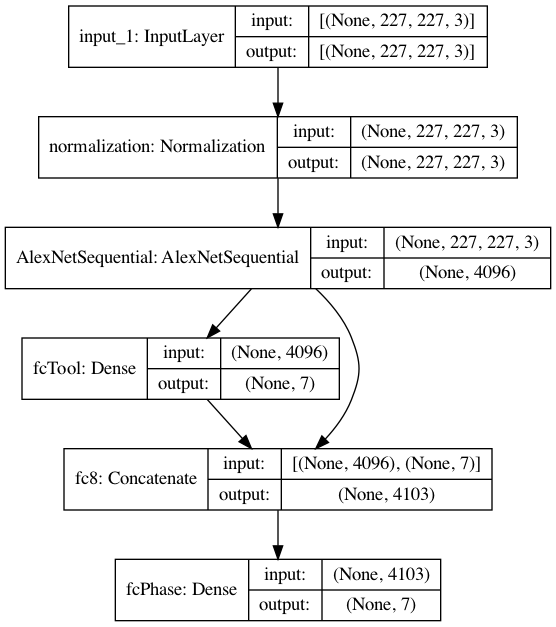

In [38]:
endoNetModel.createGraph()

## 6.3 Compile Model

In [39]:
endoNetModel.compileModel()

1. Configuring Optimizers
2. Configuring Losses
3. Compiling Model
4. Configuring Metrics
5. Initializing Checkpoint
Model Compiled!


## 6.4 Start Tensorboard

In [40]:
%tensorboard --logdir tensorboard/logs/gradient_tape

## 6.5 Train Model

In [41]:
endoNetModel.train(trainDataset, valDataset, restoreCheckpoint=False, checkpointCycle=1000, epochs=1000)

Initializing from scratch...


 --------- Starting Training! --------- 


@ Starting Epoch: 0
----------------------------------------------------
0.1 Batch Training Loss | Step 0: 84.8453.
0.2 Processed Samples: 50.
0.1 Batch Training Loss | Step 50: 59.2093.
0.2 Processed Samples: 2550.
0.1 Batch Training Loss | Step 100: 53.2884.
0.2 Processed Samples: 5050.
0.1 Batch Training Loss | Step 150: 55.6568.
0.2 Processed Samples: 7550.
0.1 Batch Training Loss | Step 200: 54.4726.
0.2 Processed Samples: 10050.
0.1 Batch Training Loss | Step 250: 64.5382.
0.2 Processed Samples: 12550.
0.1 Batch Training Loss | Step 300: 52.6963.
0.2 Processed Samples: 15050.
0.1 Batch Training Loss | Step 350: 59.2093.
0.2 Processed Samples: 17550.
0.1 Batch Training Loss | Step 400: 63.3540.
0.2 Processed Samples: 20050.

0.3 Training Metrics
Training Tools AUC | Tools | 0.8337
Training Tools Accuracy | Tools | 0.8413
Training Tools Precision | Tools | 0.5753
Training Tools Recall | Tools | 0.8189
Trainin

2021-08-25 13:33:50.211562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 4482 of 8000
2021-08-25 13:33:55.096480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Validation Tools AUC | Tools | 0.8358
Validation Tools Accuracy | Tools | 0.8433
Validation Tools Precision | Tools | 0.5751
Validation Tools Recall | Tools | 0.8232
Validation Phase AUC | Phase | 0.5653
Validation Phase Accuracy | Phase | 0.7871
Validation Phase Precision | Phase | 0.2548
Validation Phase Recall | Phase | 0.2548

| Validation Time: 1189.71 


---- Total Time: 1189.71

>>>> Saving New Best Model with Loss: 59.20933151245117 at Epoch: 0


2021-08-25 13:36:00.231998: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/best/assets
----------------------------------------------------
@ Ending Epoch: 0


@ Starting Epoch: 1
----------------------------------------------------
1.1 Batch Training Loss | Step 0: 58.0251.
1.2 Processed Samples: 50.
1.1 Batch Training Loss | Step 50: 53.8805.
1.2 Processed Samples: 2550.
1.1 Batch Training Loss | Step 100: 46.1833.
1.2 Processed Samples: 5050.
1.1 Batch Training Loss | Step 150: 52.1042.
1.2 Processed Samples: 7550.
1.1 Batch Training Loss | Step 200: 42.6307.
1.2 Processed Samples: 10050.
1.1 Batch Training Loss | Step 250: 60.3935.
1.2 Processed Samples: 12550.
1.1 Batch Training Loss | Step 300: 58.6172.
1.2 Processed Samples: 15050.
1.1 Batch Training Loss | Step 350: 64.5382.
1.2 Processed Samples: 17550.
1.1 Batch Training Loss | Step 400: 56.8410.
1.2 Processed Samples: 20050.

1.3 Training Metrics
Training Tools AUC | Tools | 0.8346
Training Tools Accuracy | Tools | 0.8434
Training Tools Precision | Tools | 

6.1 Batch Training Loss | Step 0: 59.2093.
6.2 Processed Samples: 50.
6.1 Batch Training Loss | Step 50: 57.4330.
6.2 Processed Samples: 2550.
6.1 Batch Training Loss | Step 100: 58.6172.
6.2 Processed Samples: 5050.
6.1 Batch Training Loss | Step 150: 60.3935.
6.2 Processed Samples: 7550.
6.1 Batch Training Loss | Step 200: 59.8014.
6.2 Processed Samples: 10050.
6.1 Batch Training Loss | Step 250: 49.1437.
6.2 Processed Samples: 12550.
6.1 Batch Training Loss | Step 300: 52.6963.
6.2 Processed Samples: 15050.
6.1 Batch Training Loss | Step 350: 69.2749.
6.2 Processed Samples: 17550.

**** Saved checkpoint for step 3000 in epoch 6: checkpoints/ckpt-3
6.1 Batch Training Loss | Step 400: 58.0251.
6.2 Processed Samples: 20050.

6.3 Training Metrics
Training Tools AUC | Tools | 0.8352
Training Tools Accuracy | Tools | 0.8433
Training Tools Precision | Tools | 0.5766
Training Tools Recall | Tools | 0.8217
Training Phase AUC | Phase | 0.4681
Training Phase Accuracy | Phase | 0.7395
Training 

## 6.6 Predict

In [62]:
modelLoader = ModelWriter()
bestModel = modelLoader.loadModel('initialBest')



initialBest has 18 trainable variables: conv1/kernel:0, conv1/bias:0, conv2/kernel:0, conv2/bias:0, conv3/kernel:0, conv3/bias:0, conv4/kernel:0, conv4/bias:0, conv5/kernel:0, conv5/bias:0, fc6/kernel:0, fc6/bias:0, fc7/kernel:0, fc7/bias:0, fcTool/kernel:0, fcTool/bias:0, fcPhase/kernel:0, fcPhase/bias:0


initialBest also has 0 non-trainable variables: 


In [66]:
def testOneSample(sampleBatch):
    toolsLogits, phaseLogits = bestModel(tf.reshape(sampleBatch[0], [1, 227, 227, 3]))

    frameImage = tf.keras.preprocessing.image.array_to_img(sampleBatch[0])
    
#     plt.imshow(frameImage * 255.0)
    plt.imshow(frameImage)
    
    toolsPredicts = sigmoid(toolsLogits)    
    phasePredicts = softmax(phaseLogits)
    
    print("toolsPredicts: {}".format(toolsPredicts))
    print("toolsTruth: {}".format(sampleBatch[1]))
    print("phasePredicts: {}".format(phasePredicts))
    print("phaseTruth: {}".format(sampleBatch[2]))

In [67]:
currentSample = next(iter(valDataset))

toolsPredicts: [[1. 0. 0. 0. 0. 0. 0.]]
toolsTruth: [0. 0. 0. 0. 0. 0. 0.]
phasePredicts: [[1. 0. 0. 0. 0. 0. 0.]]
phaseTruth: [1. 0. 0. 0. 0. 0. 0.]


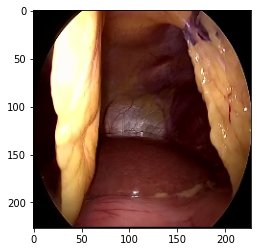

In [68]:
testOneSample(currentSample)

# 7. SVM

In [54]:
class EndoNetSVM():
    def __init__(self):
        self.svm = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))   
        
    def train(self, xTrain, yTrainOneHot, xValidation, yValidationOneHot):
        self.svm.fit(xTrain, yTrainOneHot)
        
        yPredictOneHot = self.predict(xValidation)
        
        yPredict=np.argmax(yPredictOneHot, axis=1)
        yValidation=np.argmax(yValidationOneHot, axis=1)
        
        accuracy = accuracy_score(yValidation, yPredict)
        precision = precision_score(yValidation, yPredict, average='micro')
        recall = recall_score(yValidation, yPredict, average='micro')  
        
        print('Acurracy: {0:0.2f}'.format(accuracy))
        print('Precision: {0:0.2f}'.format(precision))
        print('Recall: {0:0.2f}'.format(recall))        
        
    def predict(self, X):
        return self.svm.decision_function(X)
    
    def predictProbabilities(self, X):
        return self.svm.predict_proba(X)

Instantiate SVM

In [55]:
endoNetSVM = EndoNetSVM()

Mocking some test data in the shape of image features:

In [56]:
np.random.seed(2)
xTrain = np.random.rand(50, 4103)
hotPositions = np.random.randint(7, size=(50))
yTrain = np.zeros((hotPositions.size, hotPositions.max()+1))
yTrain[np.arange(hotPositions.size), hotPositions] = 1

In [57]:
print(xTrain.shape)
print(yTrain.shape)

(50, 4103)
(50, 7)


Training SVM

In [58]:
endoNetSVM.train(xTrain, yTrain, xTrain, yTrain)

Acurracy: 1.00
Precision: 1.00
Recall: 1.00


Testing prediction:

In [60]:
endoNetSVM.predict(xTrain)

array([[ 1.00006136, -0.99941997, -1.00000331, -0.99999753, -1.00040859,
        -0.99978099, -0.99997436],
       [-1.00002303, -0.99960489, -0.99986167, -0.99967719, -0.99988699,
         1.00011534, -1.00017116],
       [-0.99984985, -1.00034419, -0.99970245, -0.99994543, -1.00035703,
         0.99962154, -1.00024135],
       [-1.00033208, -0.99965323, -0.99967594, -0.99982744,  1.00006675,
        -0.99993239, -0.99983761],
       [-1.00003023, -1.00004434, -1.00014999,  1.00011356, -0.99979337,
        -1.00008171, -1.00003554],
       [-1.00009483, -0.99995403, -0.99981956, -0.99991237,  1.00010451,
        -1.00029583, -0.99974879],
       [-1.00002512,  0.99993978, -0.99958593, -1.00016973, -0.99965148,
        -1.00002562, -0.99999317],
       [-1.00002976, -1.00010587, -0.99956596, -1.00013798, -0.99976909,
         0.99992711, -1.00017131],
       [-0.99983035, -1.0000901 , -1.00012317,  1.00003221, -0.99993944,
        -0.9998421 , -0.99987183],
       [-1.00047508, -1.0001

Testing probability predictions:

In [61]:
endoNetSVM.predictProbabilities(xTrain)

array([[1.33728411e-01, 4.02310290e-01, 4.45315959e-01, 6.29471087e-01,
        1.99152240e-01, 2.57837336e-01, 8.36758216e-01],
       [1.45144062e-01, 4.02936345e-01, 4.45034508e-01, 6.28562622e-01,
        1.99156402e-01, 3.00009682e-02, 8.37060477e-01],
       [1.45143040e-01, 4.05444450e-01, 4.44718205e-01, 6.29323306e-01,
        1.99152652e-01, 3.00189368e-02, 8.37168181e-01],
       [1.45145887e-01, 4.03100086e-01, 4.44665550e-01, 6.28988685e-01,
        2.15593409e-01, 2.57872756e-01, 8.36547913e-01],
       [1.45144105e-01, 4.04426187e-01, 4.45607464e-01, 1.00000010e-07,
        1.99157149e-01, 2.57907695e-01, 8.36852228e-01],
       [1.45144486e-01, 4.04119779e-01, 4.44950858e-01, 6.29229550e-01,
        2.15593728e-01, 2.57957800e-01, 8.36411215e-01],
       [1.45144075e-01, 1.00000010e-07, 4.44486767e-01, 6.29959558e-01,
        1.99158281e-01, 2.57894570e-01, 8.36787126e-01],
       [1.45144102e-01, 4.04635024e-01, 4.44447102e-01, 6.29869494e-01,
        1.99157342e-01, 3

# HMM | WIP

In [117]:
from hmmlearn import hmm

In [133]:
class EndoNetHMM():
    def __init__(self, dataGenerator, videoIds, components=7, iterations=1000):
        self.components = components
        self.iterations = iterations
        self.model = hmm.GaussianHMM(n_components=components, covariance_type="full", n_iter=iterations)
        self.dataGenerator = dataGenerator
        self.videoIds = videoIds
        
        # Sequences used to construct top level topology
        self.allVideoPhaseSequences = []
        self.allVideoPhaseSequenceLengths = []        
        
    def constructTopLevelTopology(self):
        self.prepareDataForTraining()
        
        X = np.concatenate(self.allVideoPhaseSequences)
        
        result = self.model.fit(X, self.allVideoPhaseSequenceLengths)
        
        print("Topology Constructed")
        
        print("Printing Model Monitor")
        print(self.model.monitor_)
        
        print("Model Converged?: {}".format(self.model.monitor_.converged))
        
        
        return result
        
    def predict(self, predictionData):
        self.model.predict(predictionData)    
    
    def prepareDataForTraining(self):
        print("Preparing Data for Training.")
        # 1. Processing each video
        for videoId in self.videoIds:
            # 2. Generate video data
            currentVideoData = self.dataGenerator.readTFRecords([videoId])
            
            # 3. Extract phases from video
            currentVideoPhases = np.array([ [sample['phaseTarget'].numpy()] for sample in iter(currentVideoData) ])
            
            # 4. Append phase sequence and its length
            self.allVideoPhaseSequences.append(currentVideoPhases.tolist())
            self.allVideoPhaseSequenceLengths.append(len(currentVideoPhases))

In [134]:
hmmModel = EndoNetHMM(dataGenerator, videosIds)

In [135]:
hmmModel.constructTopLevelTopology()

Preparing Data for Training.
Topology Constructed
Printing Model Monitor
ConvergenceMonitor(
    history=[-66194.55284020951, -50632.008329354765, -40851.06870229679, -28738.690283600754, -15349.822224583082, 29927.305122243546, 122407.38074536115, 148880.168748186, 149208.15700561425, 149540.90650392743, 149740.1937655882, 149810.44367411055, 149843.96799253815, 149852.48481260237, 149852.99290990393, 149852.99855731308],
    iter=16,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)
Model Converged?: True


GaussianHMM(covariance_type='full', n_components=7, n_iter=1000)

# 8. Improvement | Tryouts

## 8.1 Batch Normalization

Addressing **Internal Covariate Shift (ICF)** which slows training. ICF arises do to changes in the distribution of hidden neurons, by covariate shift - hidden neuron feature space shifting based on input batch distribution. **Trainable** layer.

* **Input:** Values of $x$ over a mini-batch: $B = {x_1...m};$
* **Learning Parameters:** $\gamma, \beta$
* **Output:** $\{y_i = BN_{\gamma,\beta}(x_i)\}$
* **Algorithm:**
1.Normalize batch $B$ to zero mean and unit variance:

1.1 Calculate mini-batch mean: $\mu B \leftarrow \frac{1}{m}\sum\limits_{i=1}^m x_i$

1.2 Calculate mini-batch variance: $\sigma_B^2 \leftarrow \frac{1}{m}\sum\limits_{i=1}^m (x_i - \mu B)^2$

1.3 Normalize mini-batch: $\hat{x}_i \leftarrow \frac{x_i - \mu B}{\sqrt{\sigma_B^2 + \epsilon}}$

2.Introduce trainable paramteres $\gamma$ for scaling and $\beta$ for shifting, and feed the scaled and shifted normalized mini-batch to the activation function:
    
$y_i \leftarrow \gamma \hat{x}_i + \beta \equiv BN_{\gamma,\beta} (x_i)$

In this way the training algorithm decides when normalization is required (i.e. $\gamma= \sigma^2 B$ and $\beta = \mu B$ original activations are restored).

<img src="images/BN.jpg" alt="Batch Normalization" class="bg-primary" width="600px">
<center>Visual example for $(C,H,W) = (4, 4, 4)$, and $B=3$. [<a href=https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac target="_blank">Source</a>]</center>

Benefits:

* Higher learning rate without exploding or vanishing gradients.
* More stable gradient propagation.
* Regularization effect, by processing entire mini-batch together.
* Makes possible the use of saturating non-linearities.

Benefits:
* Faster than LRN

## 8.2 Data Augmentation

Artificially enlarge the dataset using label-preserving transformations. Preferabily low computation transformations.

Based on AlexNet paper:

1. Image translations and horizontal reflections. I.e. $224 \times 224 \times 3$ patches from four corners and center of image used in training and also for prediction by averaging the predictions. 

2. Altering RGB intensities in training images, by performing **Principal component analysis**, reducing dimensionality while minimizing information loss, to create new variables that maximize variance. 

Specifically, we add multiples of the found principal components with magnitudes proportional to the corresponding eigenvalues times a random variable drawn from a $G(\mu=0, \sigma=0.1)$:

<center>$I_{xy}=[I^R_{xy}, I^G_{xy}, I^B_{xy}]^T = [p_1, p_2, p_3][\alpha_1 \lambda_1, \alpha_2 \lambda_2, \alpha_2 \lambda_2]^T$</center>

where 
* $p_i$ - $i$th eigenvector of the $3 \times 3$ covariance matrix of RGB pixel values
* $\lambda_i$ - $i$th eigenvalue of the $3 \times 3$ covariance matrix of RGB pixel values
* $\alpha_i$ - random variable, drawn once per image processing

Benefits:

* Reducing overfitting

## 8.3 Inception instead of AlexNet

<img src="images/NetworksComparison.png" alt="Networks Comparison" class="bg-primary" width="600px">
<center>Models Comparison. [<a href=https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96 target="_blank">Source</a>]</center>

## 8.4 Incorporate temporal dimension into network features

# TODOs

* Inception
* Cross Validation
* Tensorboard
    * Kernel Images
    * Graph
* HMM Implementation
* Weight Sampling

# References

1. [Workflow Monitoring based on 3D Motion Features. Nicolas Padoy, Diana Mateus, Daniel Weinland, Marie-Odile Berger, Nassir Navab](https://hal.inria.fr/inria-00429355/document)
2. [Using Data to Enhance Performance and Improve Quality and Safety in Surgery. Mitchell G. Goldenberg, MBBS; James Jung, MD; Teodor P. Grantcharov](https://jamanetwork.com/journals/jamasurgery/article-abstract/2647848)
3. [Underreporting of Veress Needle Injuries: Comparing Direct Observation and Chart Review Methods. James J. Jung, Robert Chris Adams-McGavin, Teodor P. Grantcharov](https://pubmed.ncbi.nlm.nih.gov/30694765/)
4. [Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. Laith Alzubaidi, Jinglan Zhang, Amjad J. Humaidi, Ayad Al‐Dujaili, Ye Duan, Omran Al‐Shamma, J. Santamaría, Mohammed A. Fadhel, Muthana Al‐Amidie and Laith Farhan8](https://link.springer.com/article/10.1186/s40537-021-00444-8)
5. [Intraoperative video analysis and machine learning models will change the future of surgical training. Michal Kawka, Tamara MH. Gall, Chihua Fang, Rong Liu, Long R. Jiao](https://www.sciencedirect.com/science/article/pii/S266667662100003X)
6. [ImageNet Classification with Deep Convolutional Neural Networks. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
7. [Evaluation of Deep Learning Models for Identifying Surgical Actions and Measuring Performance. Shuja Khalid, Mitchell Goldenberg, Teodor Grantcharov, Babak Taati, Frank Rudzicz.](https://pubmed.ncbi.nlm.nih.gov/32227178/)
8. [EndoNet: A Deep Architecture for Recognition Tasks on Laparoscopic Videos. Andru P. Twinanda, Sherif Shehata, Didier Mutter, Jacques Marescaux, Michel de Mathelin, Nicolas Padoy](https://arxiv.org/abs/1602.03012)
9. [Deep Residual Learning for Image Recognition. Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.](https://arxiv.org/abs/1512.03385)
10. [Deep learning visual analysis in laparoscopic surgery: a systematic review and diagnostic test accuracy meta‐analysis. Roi Anteby, Nir Horesh, Shelly Soffer, Yaniv Zager, Yiftach Barash, Imri Amiel, Danny Rosin, Mordechai Gutman, Eyal Klang](https://pubmed.ncbi.nlm.nih.gov/33398560/)
11. [Artificial Intelligence in Surgery: Promises and Perils. Daniel A Hashimoto, Guy Rosman, Daniela Rus, Ozanan R Meireles](https://pubmed.ncbi.nlm.nih.gov/29389679/)
12. [Acute mental stress and surgical performance. P. D. Grantcharov, T. Boillat, S. Elkabany, K. Wac, and H. Rivas](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6354185/)
13. [A tutorial on Hidden Markov Models and Selected Applications in Speech Recognition. Lawrence R. Rabiner](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf)
14. [A Gentle Tutorial of the EM Algorithm and its Application to Parameter Estimation for Gaussian Mixture and Hidden Markov Models. Jeff A. Bilmes](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf)
15. [A guide to convolution arithmetic for deep learning. Vincent Dumoulin, Francesco Visin](https://arxiv.org/abs/1603.07285)
16. [Batch normalization: Accelerating deep network training by reducing internal covariate shift. Ioffe, Sergey, and Christian Szegedy. 2015](https://arxiv.org/abs/1502.03167)

# Annex - Components Not Used Anymore

## Videos to Frame

1. Generating frames for Video 4

In [ ]:
# dataGenerator.generateFrames([6])

2. Displaying first 9 examples:

In [ ]:
# images, tools, phases = dataGenerator.readFrames(1, 9).__getitem__(0)

In [ ]:
# plt.figure(figsize=(10, 10), dpi=100)

# figureIndex = 0
# for image, tool, phase in zip(images, tools, phases):
    
#     ax = plt.subplot(3, 3, figureIndex + 1)
#     figureIndex += 1
    
#     frameImage = tf.keras.preprocessing.image.array_to_img(image)
#     plt.imshow(frameImage)
#     plt.title("Phase: {}".format(labelToPhaseDecoding[phase]))
# #     plt.axis("off")
#     plt.xlabel("Instruments: {}".format(tool))

## Data Sequencer

In [ ]:
class DataSequence(Sequence):
    '''Batch based data generator from frames'''
    
    def __init__(self, videoId, framesDirectory, toolsDict, phaseDict, batchSize):
        """
        Arguments:
         * framesDirectory - directory in which frames are stored
         * toolsDict - processed tool annotations dictionary by frame ID
         * phaseDict - processed phase annotations dictionary by frame ID
         * batchSize
         
        Members:
        * __phaseToLabelEncoding - encoding map of phase Labels
        * __pathSubstring - substring used to infer frame ID from frame file name
        * __typeSubstring - substring used to infer frame ID from frame file name
        * __framesFileNames - sorted list of all frame file names
        * __toolsAnnotations - sorted list of all tool annotations
        * __phaseAnnotations - sorted list of all phase annotations
        """
        
        self.__phaseToLabelEncoding = {
            "Preparation": 0,
            "CalotTriangleDissection" : 1,
            "ClippingCutting" : 2,
            "GallbladderDissection" : 3,
            "GallbladderPackaging" : 4,
            "CleaningCoagulation" : 5,
            "GallbladderRetraction" : 6,
        }
            
        self.__videoId = videoId
        
        self.__pathSubstring = "{}/video{}_".format(framesDirectory, str(self.__videoId).zfill(2))
        self.__typeSubstring = ".png"
        
        self.__framesFileNames = [frameFileName for frameFileName in glob('{}/*.png'.format(framesDirectory))]
        self.__framesFileNames.sort()
        
        frameIds = self.__getFrameIds()
        
        self.__toolsAnnotations = [toolsDict[key] for key in frameIds]
        self.__phaseAnnotations = [self.__phaseToLabelEncoding[phaseDict[key]] for key in frameIds]
        
        self.batchSize = batchSize
        
    def __len__(self):
        '''Returns number of batches.'''
        return int(np.ceil(len(self.__framesFileNames) / float(self.batchSize)))
    
    def __getFrameIds(self):
        '''Returns sorted list of frame IDs.'''
        
        frameIds = [int(fileName.replace(self.__pathSubstring, '').replace(self.__typeSubstring, '')) for fileName in self.__framesFileNames]
        frameIds.sort()
        
        return frameIds
    
    def __processBatchFrame(self, frame):
        '''Load from file, transform in array and return frame.'''    
        return tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(frame))
    
    def __getitem__(self, idx):
        '''Builds and returns current batch.'''
        
        batchFileNames = self.__framesFileNames[idx * self.batchSize:(idx + 1) * self.batchSize]
        batchX = [self.__processBatchFrame(fileName) for fileName in batchFileNames]
        batchY_tools = self.__toolsAnnotations[idx * self.batchSize:(idx + 1) * self.batchSize]
        batchY_phases = self.__phaseAnnotations[idx * self.batchSize:(idx + 1) * self.batchSize]
    
        return np.array(batchX), np.array(batchY_tools), np.array(batchY_phases)    

## Alex Net |  Subclassing Model

In [ ]:
class AlexNetModel(Model):
    def __init__(self, input_shape, weightsFile='pretrained_weights/alexnet.npy', name="AlexNetModel", **kwargs):
        super(AlexNetModel, self).__init__(name=name,**kwargs)
        
        self.x_shape = input_shape
        self.weightsPath = weightsFile
        self.weightsInitializer = tf.keras.initializers.Zeros()
        
        # 1. 1st Layer: Conv -> Relu -> LRN -> MaxPool (2 groups)
        # 1.1 ConvOutput =  (227 - 11 + 2 * 0) / 4 + 1 = 55 |> (55, 55, 96)
        # 1.2 Parameters = (11 * 11 * 3 + 1) * 96 = 34,944
        self.conv1 = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', groups=1, name='conv1', input_shape=self.x_shape, kernel_initializer=self.weightsInitializer)
        self.relu1 = Activation('relu', name='relu1')
        self.norm1 = LocalResponseNormalization(depth_radius=2, bias=1.0, alpha=2e-5, beta=0.75, name="norm1")
        # 1.3 MaxOutput =  (55 - 3) / 2 + 1 = 27 |> (27, 27, 96)        
        self.pool1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1')
        
        # 2. 2nd Layer: Conv -> Relu -> LRN -> MaxPool (2 groups) 
        # 2.1 Padding = ((1 - 1) * 27 - 1 + 5)/2 = 2
        # 2.2 ConvOutput =  (27 - 5 + 2 * 2) / 1 + 1 = 27 |> (27, 27, 256)
        # 2.3 Parameters = (5 * 5 * 96 + 1) * 256 = 614,656
        self.conv2 = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', groups=2, name='conv2', kernel_initializer=self.weightsInitializer)
        self.relu2 = Activation('relu', name='relu2')
        self.norm2 = LocalResponseNormalization(depth_radius=2, bias=1.0, alpha=2e-5, beta=0.75, name="norm2")
        # 2.4 MaxOutput =  (27 - 3) / 2 + 1 = 13 |> (13, 13, 256)        
        self.pool2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool2')
        
        # 3. 3rd Layer: Conv -> Relu
        # 3.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 3.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 384)
        # 3.3 Parameters = (3 * 3 * 256 + 1) * 384 = 885,120
        self.conv3 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=1, name='conv3', kernel_initializer=self.weightsInitializer)
        self.relu3 = Activation('relu', name='relu3')
        
        # 4. 4th Layer: Conv -> Relu (2 groups)
        # 4.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 4.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 384)
        # 4.3 Parameters = (3 * 3 * 384 + 1) * 384 = 1,327,488
        self.conv4 = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=2, name='conv4', kernel_initializer=self.weightsInitializer)
        self.relu4 = Activation('relu', name='relu4')
        
        # 5. 5th Layer: Conv -> Relu -> MaxPool (2 groups)
        # 5.1 Padding = ((1 - 1) * 13 - 1 + 3)/2 = 1
        # 5.2 ConvOutput =  (13 - 3 + 2 * 1) / 1 + 1 = 13 |> (13, 13, 256)
        # 5.3 Parameters = (3 * 3 * 384 + 1) * 256 = 884,992
        self.conv5 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=2, name='conv5', kernel_initializer=self.weightsInitializer)
        self.relu5 = Activation('relu', name='relu5')
        # 5.2 MaxOutput =  (13 - 3) / 2 + 1 = 6 |> (6, 6, 256)        
        self.pool5 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool5')
        
        # FlattenOutput = 6 * 6 * 256 = 9,216
        self.flatten = Flatten()
        
        # 6. 6th Layer: FC -> Relu -> Dropout
        # Parameters = 4,096 * 9,216 + 4,096 = 37,752,832
        self.fc6 = Dense(4096, name='fc6', kernel_initializer=self.weightsInitializer)
        self.relu6 = Activation('relu', name='relu6')
        self.dropout6 = Dropout(0.5, name='dropout6')
        
        # 7. 7th Layer: FC -> Relu -> Dropout
        # Parameters = 4,096 * 4,096 + 4,096 = 16,781,312
        self.fc7 = Dense(4096, name='fc7', kernel_initializer=self.weightsInitializer)
        self.relu7 = Activation('relu', name='relu7')
        self.dropout7 = Dropout(0.5, name='dropout7')
        
    def summary(self):
        inputLayer = Input(self.x_shape)
        model = Model(inputs=[inputLayer], outputs=self.call(inputLayer))
        return model.summary()        
        
    def readWeights(self):
        self.preloadedWeights = np.load(self.weightsPath, allow_pickle=True, encoding='latin1').item()
        
        print('Preloaded Conv1: {}'.format(self.preloadedWeights['conv1'][0].shape))
        print('Network Conv1: {}'.format(11 * 11 * 3 * 96 + 96))

        print('Preloaded Conv2: {}'.format(self.preloadedWeights['conv2'][0].shape))
        print('Network Conv2: {}'.format((5 * 5 * 48 * 256) * 2 + 256))

        print('Preloaded Conv3: {}'.format(self.preloadedWeights['conv3'][0].shape))
        print('Network Conv3: {}'.format((3 * 3 * 256 * 384) + 384))

        print('Preloaded Conv4: {}'.format(self.preloadedWeights['conv4'][0].shape))
        print('Network Conv4: {}'.format((3 * 3 * 192 * 384) * 2 + 384))

        print('Preloaded Conv5: {}'.format(self.preloadedWeights['conv5'][0].shape))
        print('Network Conv5: {}'.format((3 * 3 * 192 * 256) * 2 + 256))

        print('Preloaded FC6: {}'.format(self.preloadedWeights['fc6'][0].shape))
        print('Network FC6: {}'.format(9216 * 4096 + 4096))

        print('Preloaded FC7: {}'.format(self.preloadedWeights['fc7'][0].shape))
        print('Network FC7: {}'.format(4096 * 4096 + 4096))
        
    def setWeights(self):
        self.conv1.set_weights(self.preloadedWeights['conv1'])
        self.conv2.set_weights(self.preloadedWeights['conv2'])
        self.conv3.set_weights(self.preloadedWeights['conv3'])
        self.conv4.set_weights(self.preloadedWeights['conv4'])
        self.conv5.set_weights(self.preloadedWeights['conv5'])
        self.fc6.set_weights(self.preloadedWeights['fc6'])
        self.fc7.set_weights(self.preloadedWeights['fc7'])  
        
    def loadWeights(self):
        self.readWeights()
        self.setWeights()        

    def call(self, inputs):
        
        # 1st Layer Pass
        conv1Output = self.conv1(inputs)
        relu1Output = self.relu1(conv1Output)
        norm1Output = self.norm1(relu1Output)
        pool1Output = self.pool1(norm1Output)
 
        # 2nd Layer Pass
        conv2Output = self.conv2(pool1Output)
        relu2Output = self.relu2(conv2Output)
        norm2Output = self.norm2(relu2Output)
        pool2Output = self.pool2(norm2Output)  
        
        # 3rd Layer Pass
        conv3Output = self.conv3(pool2Output)
        relu3Output = self.relu3(conv3Output)
        
        # 4th Layer Pass
        conv4Output = self.conv4(relu3Output)
        relu4Output = self.relu4(conv4Output)   
        
        # 5th Layer Pass
        conv5Output = self.conv5(relu4Output)
        relu5Output = self.relu5(conv5Output)   
        pool5Output = self.pool5(relu5Output)
        
        flattenOutput = self.flatten(pool5Output)
        
        # 6th Layer Pass
        fc6Output = self.fc6(flattenOutput)
        relu6Output = self.relu6(fc6Output)
        dropout6Output = self.dropout6(relu6Output)
        
        # 7th Layer Pass
        fc7Output = self.fc7(dropout6Output)
        relu7Output = self.relu7(fc7Output)
        dropout7Output = self.dropout7(relu7Output)        
        
        # Total Parameters = 34,944 + 614,656 + 885,120 + 1,327,488 + 884,992 + 37,752,832 + 16,781,312 = 58,281,344 
        
        return dropout7Output

Create model and build it:

In [ ]:
batch_size = 32
alexNetModel = AlexNetModel((227, 227, 3))
alexNetModel.build((batch_size, 227, 227, 3))

In [ ]:
print("Weights:", len(alexNetModel.weights))
print("Trainable Weights:", len(alexNetModel.trainable_weights))
print("Non Trainable Weights:", len(alexNetModel.non_trainable_weights))

Load pre-trained weights:

In [ ]:
alexNetModel.loadWeights()

Check model summary:

In [ ]:
alexNetModel.summary()

## Endo Net | Model Subclassing

In [ ]:
class EndoNetModel(Model):
    def __init__(self, inputShape, alexNet, name='EndoNetModel', **kwargs):
        super(EndoNetModel, self).__init__(name=name, **kwargs)
        
        kernelInitializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.x_shape = inputShape
        
        self.alexNet = alexNet
        self.fcTool = Dense(7, name='fcTool', kernel_initializer=kernelInitializer)
        self.fc8 = Concatenate(axis=1, name="fc8")
        self.fcPhase = Dense(7, name='fcPhase', kernel_initializer=kernelInitializer)   
        
        self.mlbc = MultiLabelBinaryCrossentropy()
        self.smlf = SoftmaxMultinomialLogisticFunction()
        
        self.mlbcMetric = tf.keras.metrics.Mean(name="CrossEntropy")
        self.smlfMetric = tf.keras.metrics.Mean(name="Softmax")
        self.totalLossMetric = tf.keras.metrics.Mean(name="TotalLoss")
        
    def summary(self):
        inputLayer = Input(self.x_shape)
        model = Model(inputs=[inputLayer], outputs=self.call(inputLayer))
        return model.summary()
    
    def train_step(self, data):


        with tf.GradientTape() as tape:
            frames, _, _, tools, phases = data
            
            print("here")
            toolsPredictions = self.fcTool(frames, training=True)
            phasePredictions = self(frames, training=True)
            
            print("after")
            toolsLoss = self.mlbc(toolsTruth, toolsPredictions)
            phaseLoss = self.mlbc(phaseTruth, phasePredictions)
            
            loss = toolsLoss + phaseLoss
            
            
        
        trainableVars = self.trainable_vars
        gradients = tape.gradient(loss, trainableVars)
        
        self.optimizer.apply_gradients(zip(gradients, trainableVars))
        
        self.mlbcMetric.update_state(toolsLoss)
        self.smlfMetric.update_state(phaseLoss)        
        self.totalLossMetric.update_state(totalLossMetric)        
        
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.mlbcMetric, self.smlfMetric, self.totalLossMetric]
        
       
    def call(self, inputs):
        alexNetOutput = self.alexNet(inputs)
        fcToolOutput = self.fcTool(alexNetOutput)
        fc8Output = self.fc8([alexNetOutput, fcToolOutput])
        fcPhaseOutput = self.fcPhase(fc8Output)
        
        return fcToolOutput, fcPhaseOutput